# Anticipez les besoins en consommation électrique de bâtiments

Based on the data hosted by the City of Seattle and providing information on non-residential buildings, we will design an application that predicts CO2 emissions and total energy consumption of buildings based on their characteristics. 

The construction stages of our application are:

1. Data mining
    - Merge databases
    - Univariate analysis
    - Multivariate analysis


2. Modeling
    - Modeling
    - Choose the best model

In this Notebook, we will apply data preprocessing.

## Merge datasets

### Import librairies

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Read datasets

In [2]:
data2015 = pd.read_csv('D:/IML/project3/DATA/2015-building-energy-benchmarking.csv', index_col = ['OSEBuildingID'])
data2016 = pd.read_csv('D:/IML/project3/DATA/2016-building-energy-benchmarking.csv', index_col = ['OSEBuildingID'])

In [3]:
data2015['Location'] = data2015['Location'].map(eval)
data2015 = pd.concat([data2015.drop(['Location'], axis=1), data2015['Location'].apply(pd.Series)], axis=1)

In [4]:
data2015['human_address'] = data2015['human_address'].map(eval)
data2015 = pd.concat([data2015.drop(['human_address'], axis=1), data2015['human_address'].apply(pd.Series)], axis=1)

In [5]:
data2015.shape

(3340, 51)

In [6]:
data2016.shape

(3376, 45)

In [7]:
var2015 = data2015.columns.tolist()
var2016 = data2016.columns.tolist()

In [8]:
# Find features in the dataset 2015 but not in the dataset 2016
[var for var in var2015 if var not in var2016]

['OtherFuelUse(kBtu)',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Comment',
 '2010 Census Tracts',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'City Council Districts',
 'SPD Beats',
 'Zip Codes',
 'latitude',
 'longitude',
 'address',
 'city',
 'state',
 'zip']

In [9]:
# Find features in the dataset 2016 but not in the dataset 2015
[var for var in var2016 if var not in var2015]

['Address',
 'City',
 'State',
 'ZipCode',
 'Latitude',
 'Longitude',
 'Comments',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity']

In [10]:
# Rename features that are misnamed
data2015.rename({'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions',
                 'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity',
                'Comment':'Comments',
                'latitude':'Latitude',
                'longitude':'Longitude',
                'address':'Address',
                'city':'City',
                'state':'State',
                'zip':'ZipCode'}, axis=1, inplace=True)

In [11]:
var2015 = data2015.columns.tolist()
var2016 = data2016.columns.tolist()
# All the features that are captured in 2015 but not in 2016
[var for var in var2015 if var not in var2016]

['OtherFuelUse(kBtu)',
 '2010 Census Tracts',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'City Council Districts',
 'SPD Beats',
 'Zip Codes']

In [12]:
# All the features that are captured in 2016 but not in 2015
[var for var in var2016 if var not in var2015]

[]

We have 6 features that are captured in 2015 and not in 2016. But all the features in 2016 are captured in 2015. If a feature has been stopped stracking, it means it is not relevant. So we are going to drop them.

In [13]:
data2015.drop(['OtherFuelUse(kBtu)','2010 Census Tracts', 'Seattle Police Department Micro Community Policing Plan Areas',
              'City Council Districts', 'SPD Beats', 'Zip Codes'], axis = 1, inplace = True)

In [14]:
data2015.shape

(3340, 45)

In [15]:
data2016.shape

(3376, 45)

In [16]:
var2015 = data2015.columns.tolist()
data2016 = data2016[var2015]

In [17]:
defaultdata2015 = {'No':0, 'Yes':1}
defaultdata2016 = {False:0, True:1}
data2015['DefaultData'] = data2015['DefaultData'].map(defaultdata2015)
data2016['DefaultData'] = data2016['DefaultData'].map(defaultdata2016)

### Merge the two datasets

In [18]:
data = data2015.merge(data2016,
               left_index=True, right_index=True,
                how="outer", suffixes=("_2015", "_2016")).sort_index(axis=1)

In [19]:
data.shape

(3432, 90)

After merging the two datasets, we have gotten a dataset with 3432 observations and 90 features

In [20]:
# Let's print out all the features
data.columns

Index(['Address_2015', 'Address_2016', 'BuildingType_2015',
       'BuildingType_2016', 'City_2015', 'City_2016', 'Comments_2015',
       'Comments_2016', 'ComplianceStatus_2015', 'ComplianceStatus_2016',
       'CouncilDistrictCode_2015', 'CouncilDistrictCode_2016', 'DataYear_2015',
       'DataYear_2016', 'DefaultData_2015', 'DefaultData_2016',
       'ENERGYSTARScore_2015', 'ENERGYSTARScore_2016',
       'Electricity(kBtu)_2015', 'Electricity(kBtu)_2016',
       'Electricity(kWh)_2015', 'Electricity(kWh)_2016',
       'GHGEmissionsIntensity_2015', 'GHGEmissionsIntensity_2016',
       'LargestPropertyUseTypeGFA_2015', 'LargestPropertyUseTypeGFA_2016',
       'LargestPropertyUseType_2015', 'LargestPropertyUseType_2016',
       'Latitude_2015', 'Latitude_2016', 'ListOfAllPropertyUseTypes_2015',
       'ListOfAllPropertyUseTypes_2016', 'Longitude_2015', 'Longitude_2016',
       'NaturalGas(kBtu)_2015', 'NaturalGas(kBtu)_2016',
       'NaturalGas(therms)_2015', 'NaturalGas(therms)_2016',

## Univariate and multivate Analyse

### Drop unrelevant features

#### Find and drop constant variables in the dataset

In [21]:
def categorical_filter(df, low_exclusive = 2, high_inclusive = 15):
    """function returns features (col_names) that have unique values
    less than or equal to n_categories
    
    """ 
    list_of_features = []
    for i in df.columns:
        if low_exclusive == high_inclusive:
            if df[i].nunique() <= low_exclusive :
                list_of_features.append(i)
        else:
            if df[i].nunique() <= high_inclusive and df[i].nunique() > low_exclusive :
                list_of_features.append(i)
    return list_of_features

In [22]:
#Constant variables
ConstantVar = categorical_filter(data, low_exclusive = 1, high_inclusive = 1)

In [23]:
ConstantVar

['City_2015',
 'City_2016',
 'Comments_2016',
 'DataYear_2015',
 'DataYear_2016',
 'State_2015',
 'State_2016']

In [24]:
# Even though Comments_2015 is not a constant variable, we will drop it also as Comments_2016 will be drop. 
ConstantVar.append('Comments_2015')

In [25]:
data.drop(ConstantVar, axis = 1, inplace = True)

#### Find and drop variables with high percentage of missing data in the dataset

In [26]:
PercentageOfMissingData = (data.isnull().sum()/len(data)).sort_values(ascending = False)
varToDrop = PercentageOfMissingData[PercentageOfMissingData>0.95].index
varToDrop

Index(['Outlier_2016', 'Outlier_2015', 'YearsENERGYSTARCertified_2015',
       'YearsENERGYSTARCertified_2016'],
      dtype='object')

In [27]:
data.drop(varToDrop, axis = 1, inplace = True)

#### Find and drop variables with low variance in the dataset

In [28]:
varLowVariance = ['ComplianceStatus_2015', 'ComplianceStatus_2016',
                  'DefaultData_2015', 'DefaultData_2016','NumberofBuildings_2015',
                   'NumberofBuildings_2016']
dataLowVar = data[varLowVariance]

# Label encode categories
le=LabelEncoder()
dataLowVar[['ComplianceStatus_2015', 'ComplianceStatus_2016']] = dataLowVar[['ComplianceStatus_2015', 'ComplianceStatus_2016']].fillna('NaN')
dataLowVar.loc[:,'ComplianceStatus_2015'] = le.fit_transform(dataLowVar['ComplianceStatus_2015'])
dataLowVar.loc[:,'ComplianceStatus_2016'] = le.fit_transform(dataLowVar['ComplianceStatus_2016'])

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [29]:
dataLowVar.head()

,ComplianceStatus_2015,ComplianceStatus_2016,DefaultData_2015,DefaultData_2016,NumberofBuildings_2015,NumberofBuildings_2016
OSEBuildingID,,,,,,
1,0,0,0.0,0.0,1.0,1.0
2,0,0,0.0,0.0,1.0,1.0
3,0,0,1.0,0.0,1.0,1.0
5,0,0,0.0,0.0,1.0,1.0
8,0,0,0.0,0.0,1.0,1.0


In [30]:
dataLowVar.var()

ComplianceStatus_2015     0.029496
ComplianceStatus_2016     0.351971
DefaultData_2015          0.137226
DefaultData_2016          0.032361
NumberofBuildings_2015    0.615382
NumberofBuildings_2016    4.445358
dtype: float64

We can see that all these features have a very low variance. So we will drop them from our dataset.

In [31]:
data.drop(varLowVariance, axis = 1, inplace = True)

#### Drop id variables

In our dataset, we have some features that caracterized almost unique building. These features act as Ids, so we are going to drop them from the dataset.

In [32]:
idVar = ['Address_2015', 'Address_2016', 'Latitude_2015', 'Latitude_2016', 'Longitude_2015', 'Longitude_2016',
        'PropertyName_2015', 'PropertyName_2016', 'TaxParcelIdentificationNumber_2015', 'TaxParcelIdentificationNumber_2016',
        'ZipCode_2015', 'ZipCode_2016']

In [33]:
data.drop(idVar, axis = 1, inplace = True)

#### Drop other unrelevant features

In [34]:
UnrelevantVar = ['LargestPropertyUseType_2015', 'LargestPropertyUseType_2016',
                'SecondLargestPropertyUseType_2015', 'SecondLargestPropertyUseType_2016',
                'ThirdLargestPropertyUseType_2015', 'ThirdLargestPropertyUseType_2016']

In [35]:
data.drop(UnrelevantVar, axis = 1, inplace = True)

Now the remaining variables is:

In [36]:
data.columns

Index(['BuildingType_2015', 'BuildingType_2016', 'CouncilDistrictCode_2015',
       'CouncilDistrictCode_2016', 'ENERGYSTARScore_2015',
       'ENERGYSTARScore_2016', 'Electricity(kBtu)_2015',
       'Electricity(kBtu)_2016', 'Electricity(kWh)_2015',
       'Electricity(kWh)_2016', 'GHGEmissionsIntensity_2015',
       'GHGEmissionsIntensity_2016', 'LargestPropertyUseTypeGFA_2015',
       'LargestPropertyUseTypeGFA_2016', 'ListOfAllPropertyUseTypes_2015',
       'ListOfAllPropertyUseTypes_2016', 'NaturalGas(kBtu)_2015',
       'NaturalGas(kBtu)_2016', 'NaturalGas(therms)_2015',
       'NaturalGas(therms)_2016', 'Neighborhood_2015', 'Neighborhood_2016',
       'NumberofFloors_2015', 'NumberofFloors_2016',
       'PrimaryPropertyType_2015', 'PrimaryPropertyType_2016',
       'PropertyGFABuilding(s)_2015', 'PropertyGFABuilding(s)_2016',
       'PropertyGFAParking_2015', 'PropertyGFAParking_2016',
       'PropertyGFATotal_2015', 'PropertyGFATotal_2016',
       'SecondLargestPropertyUseTypeG

Base on the above features selection, those that we will keep in our analysis are:

features = ['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 
        'NumberofFloors',  'PropertyGFATotal',  'PropertyGFABuilding(s)', 'PropertyGFAParking',
        'ListOfAllPropertyUseTypes', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
        'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore','SiteEUI(kBtu/sf)', 
        'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
        'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 
        'GHGEmissionsIntensity','TotalGHGEmissions']

### Correct None positive values

In our study, all the numeric features should be positive. So let's check whether there is any none positive value in our dataset.

In [37]:
numericVar = data.select_dtypes(np.number).columns
data[numericVar].agg(lambda x: sum(x < 0)).sum()

11

We can see that there are some negative values in our dataset. Let's isolate the features that contain negative values.

In [38]:
# Features with negative values
VarWithNegativeValues = (data[numericVar] < 0).any()
VarWithNegativeValues[VarWithNegativeValues == True]

Electricity(kBtu)_2016         True
Electricity(kWh)_2016          True
GHGEmissionsIntensity_2016     True
PropertyGFABuilding(s)_2015    True
PropertyGFAParking_2015        True
SourceEUI(kBtu/sf)_2015        True
SourceEUIWN(kBtu/sf)_2015      True
SourceEUIWN(kBtu/sf)_2016      True
TotalGHGEmissions_2016         True
dtype: bool

In [39]:
#Let's take the absolute value of all the numerical features to avoid negative values
data[numericVar] = np.abs(data[numericVar])

### Categorical variables preprocessing

#### BuildingType_2015, BuildingType_2016

In [40]:
data['BuildingType_2015'].value_counts(dropna = False)

NonResidential          1461
Multifamily LR (1-4)    1029
Multifamily MR (5-9)     554
Multifamily HR (10+)     107
SPS-District K-12         99
NaN                       92
Nonresidential COS        68
Campus                    22
Name: BuildingType_2015, dtype: int64

In [41]:
data['BuildingType_2016'].value_counts(dropna = False)

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
NaN                       56
Campus                    24
Nonresidential WA          1
Name: BuildingType_2016, dtype: int64

In [42]:
data['BuildingType_2015'] = data['BuildingType_2015'].fillna('BuildingTypeNA')
data['BuildingType_2016'] = data['BuildingType_2016'].fillna('BuildingTypeNA')

Text(0.5, 1.0, 'BuildingType_2016')

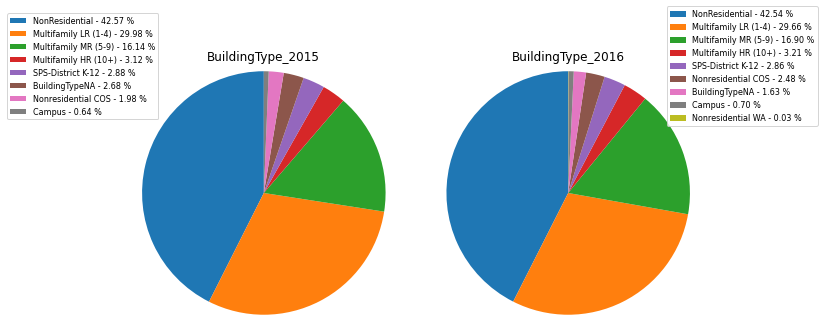

In [43]:
labels2015 = data['BuildingType_2015'].value_counts().index
sizes2015 = data['BuildingType_2015'].value_counts().values
porcent2015 = 100.*sizes2015/sizes2015.sum()

labels2016 = data['BuildingType_2016'].value_counts().index
sizes2016 = data['BuildingType_2016'].value_counts().values
porcent2016 = 100.*sizes2016/sizes2016.sum()

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
patches, texts = plt.pie(sizes2015, startangle=90, radius=1.2)
lb2015 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels2015, porcent2015)]

sort_legend = True

if sort_legend:
    patches, lb2015, dummy =  zip(*sorted(zip(patches, lb2015, sizes2015),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, lb2015, loc='center right', bbox_to_anchor=(0.1, 1.),
           fontsize=8)
plt.title('BuildingType_2015')


plt.subplot(1,2,2)
patches, texts = plt.pie(sizes2016, startangle=90, radius=1.2)
lb2016 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels2016, porcent2016)]

sort_legend = True

if sort_legend:
    patches, lb2016, dummy =  zip(*sorted(zip(patches, lb2016, sizes2016),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, lb2016, loc='center right', bbox_to_anchor=(1.5, 1.),
           fontsize=8)
plt.title('BuildingType_2016')

#### CouncilDistrictCode_2015, CouncilDistrictCode_2016

In [44]:
# Let's assume that the Council district code remains the same during years.
data.loc[data['CouncilDistrictCode_2015'].isna(), 'CouncilDistrictCode_2015'] = \
data.loc[data['CouncilDistrictCode_2015'].isna(), 'CouncilDistrictCode_2016'] 

data.loc[data['CouncilDistrictCode_2016'].isna(), 'CouncilDistrictCode_2016'] = \
data.loc[data['CouncilDistrictCode_2016'].isna(), 'CouncilDistrictCode_2015'] 

Text(0.5, 1.0, 'CouncilDistrictCode_2016')

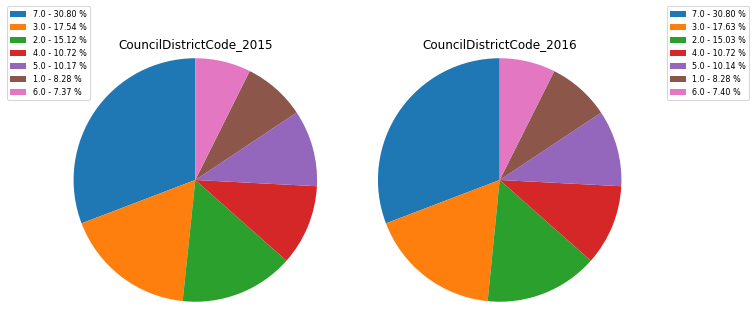

In [45]:
labels2015 = data['CouncilDistrictCode_2015'].value_counts().index
sizes2015 = data['CouncilDistrictCode_2015'].value_counts().values
porcent2015 = 100.*sizes2015/sizes2015.sum()

labels2016 = data['CouncilDistrictCode_2016'].value_counts().index
sizes2016 = data['CouncilDistrictCode_2016'].value_counts().values
porcent2016 = 100.*sizes2016/sizes2016.sum()

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
patches, texts = plt.pie(sizes2015, startangle=90, radius=1.2)
lb2015 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels2015, porcent2015)]

sort_legend = True

if sort_legend:
    patches, lb2015, dummy =  zip(*sorted(zip(patches, lb2015, sizes2015),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, lb2015, loc='center right', bbox_to_anchor=(0.1, 1.),
           fontsize=8)
plt.title('CouncilDistrictCode_2015')


plt.subplot(1,2,2)
patches, texts = plt.pie(sizes2016, startangle=90, radius=1.2)
lb2016 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels2016, porcent2016)]

sort_legend = True

if sort_legend:
    patches, lb2016, dummy =  zip(*sorted(zip(patches, lb2016, sizes2016),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, lb2016, loc='center right', bbox_to_anchor=(1.5, 1.),
           fontsize=8)
plt.title('CouncilDistrictCode_2016')

#### ListOfAllPropertyUseTypes_2015, ListOfAllPropertyUseTypes_2016

In [46]:
data[['ListOfAllPropertyUseTypes_2015', 'ListOfAllPropertyUseTypes_2016']].head()

,ListOfAllPropertyUseTypes_2015,ListOfAllPropertyUseTypes_2016
OSEBuildingID,,
1,Hotel,Hotel
2,"Hotel, Parking, Restaurant","Hotel, Parking, Restaurant"
3,"Hotel, Parking, Swimming Pool",Hotel
5,Hotel,Hotel
8,"Hotel, Parking, Swimming Pool","Hotel, Parking, Swimming Pool"


In [47]:
# Create new feature giving the number of all property use types in a building
data['NumberOfAllPropertyUseTypes_2015'] = data['ListOfAllPropertyUseTypes_2015'].str.count(',')+1
data['NumberOfAllPropertyUseTypes_2016'] = data['ListOfAllPropertyUseTypes_2016'].str.count(',')+1

In [48]:
data[['NumberOfAllPropertyUseTypes_2015', 'NumberOfAllPropertyUseTypes_2016']].head()

,NumberOfAllPropertyUseTypes_2015,NumberOfAllPropertyUseTypes_2016
OSEBuildingID,,
1,1.0,1.0
2,3.0,3.0
3,3.0,1.0
5,1.0,1.0
8,3.0,3.0


In [49]:
# We will assume that missing value in the NumberOfAllPropertyUseTypes feature means that the building in unused. 
data['NumberOfAllPropertyUseTypes_2015'] = data['NumberOfAllPropertyUseTypes_2015'].fillna(0)
data['NumberOfAllPropertyUseTypes_2016'] = data['NumberOfAllPropertyUseTypes_2016'].fillna(0)

In [50]:
data.drop(['ListOfAllPropertyUseTypes_2015', 'ListOfAllPropertyUseTypes_2016'], axis = 1, inplace = True)

#### Neighborhood_2015, Neighborhood_2016

In [51]:
data['Neighborhood_2015'] = data['Neighborhood_2015'].str.upper()
data['Neighborhood_2016'] = data['Neighborhood_2016'].str.upper()

In [52]:
# We also assume that Neighborhood remains the same in the time.
data.loc[data['Neighborhood_2015'].isna(), 'Neighborhood_2015'] = data.loc[data['Neighborhood_2015'].isna(), 'Neighborhood_2016']
data.loc[data['Neighborhood_2016'].isna(), 'Neighborhood_2016'] = data.loc[data['Neighborhood_2016'].isna(), 'Neighborhood_2015']

Text(0.5, 1.0, 'Neighborhood_2016')

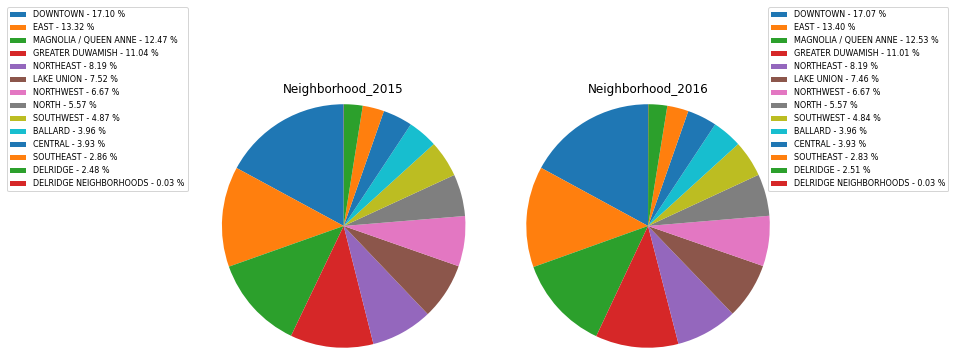

In [53]:
labels2015 = data['Neighborhood_2015'].value_counts().index
sizes2015 = data['Neighborhood_2015'].value_counts().values
porcent2015 = 100.*sizes2015/sizes2015.sum()

labels2016 = data['Neighborhood_2016'].value_counts().index
sizes2016 = data['Neighborhood_2016'].value_counts().values
porcent2016 = 100.*sizes2016/sizes2016.sum()

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
patches, texts = plt.pie(sizes2015, startangle=90, radius=1.2)
lb2015 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels2015, porcent2015)]

sort_legend = True

if sort_legend:
    patches, lb2015, dummy =  zip(*sorted(zip(patches, lb2015, sizes2015),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, lb2015, loc='center right', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
plt.title('Neighborhood_2015')


plt.subplot(1,2,2)
patches, texts = plt.pie(sizes2016, startangle=90, radius=1.2)
lb2016 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels2016, porcent2016)]

sort_legend = True

if sort_legend:
    patches, lb2016, dummy =  zip(*sorted(zip(patches, lb2016, sizes2016),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, lb2016, loc='center right', bbox_to_anchor=(1.7, 1.),
           fontsize=8)
plt.title('Neighborhood_2016')

#### PrimaryPropertyType_2015, PrimaryPropertyType_2016

In [54]:
data['PrimaryPropertyType_2015'].value_counts()

Low-Rise Multifamily           998
Mid-Rise Multifamily           539
Small- and Mid-Sized Office    297
Other                          258
Non-Refrigerated Warehouse     187
Large Office                   171
K-12 School                    136
Mixed Use Property             126
High-Rise Multifamily          103
Retail Store                   100
Hotel                           73
Worship Facility                72
Distribution Center\n           51
Senior Care Community           43
Medical Office                  43
Supermarket/Grocery Store       36
Self-Storage Facility\n         27
College/University              22
Residence Hall/Dormitory        15
Refrigerated Warehouse          13
Restaurant\n                    11
Hospital                        10
SPS-District K-12                4
Distribution Center              2
Self-Storage Facility            1
Restaurant                       1
Laboratory                       1
Name: PrimaryPropertyType_2015, dtype: int64

In [55]:
data['PrimaryPropertyType_2015'] = data['PrimaryPropertyType_2015'].replace('\n', '', regex=True)
data['PrimaryPropertyType_2016'] = data['PrimaryPropertyType_2016'].replace('\n', '', regex=True)

Text(0.5, 1.0, 'PrimaryPropertyType_2016')

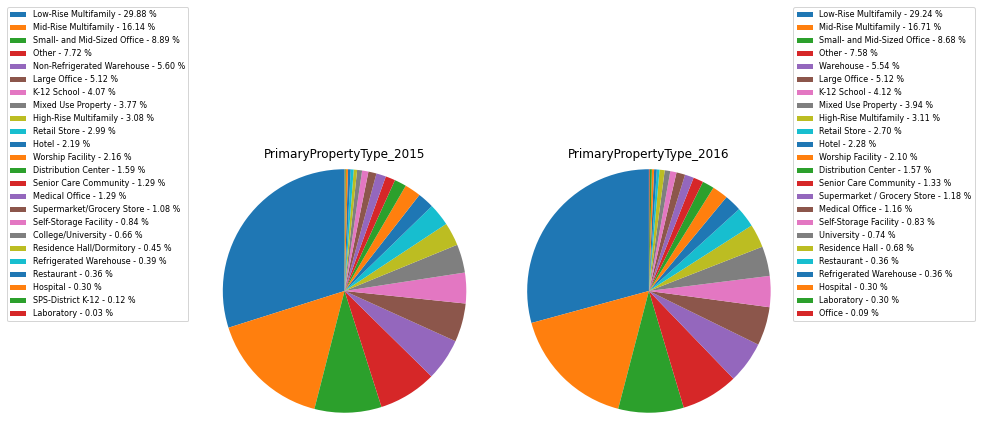

In [56]:
labels2015 = data['PrimaryPropertyType_2015'].value_counts().index
sizes2015 = data['PrimaryPropertyType_2015'].value_counts().values
porcent2015 = 100.*sizes2015/sizes2015.sum()

labels2016 = data['PrimaryPropertyType_2016'].value_counts().index
sizes2016 = data['PrimaryPropertyType_2016'].value_counts().values
porcent2016 = 100.*sizes2016/sizes2016.sum()

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
patches, texts = plt.pie(sizes2015, startangle=90, radius=1.2)
lb2015 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels2015, porcent2015)]

sort_legend = True

if sort_legend:
    patches, lb2015, dummy =  zip(*sorted(zip(patches, lb2015, sizes2015),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, lb2015, loc='center right', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
plt.title('PrimaryPropertyType_2015')


plt.subplot(1,2,2)
patches, texts = plt.pie(sizes2016, startangle=90, radius=1.2)
lb2016 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels2016, porcent2016)]

sort_legend = True

if sort_legend:
    patches, lb2016, dummy =  zip(*sorted(zip(patches, lb2016, sizes2016),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, lb2016, loc='center right', bbox_to_anchor=(1.8, 1.),
           fontsize=8)
plt.title('PrimaryPropertyType_2016')

### Numerical variables preprocessing

In [57]:
VarQCO2 = ['Electricity(kBtu)_2015', 'Electricity(kBtu)_2016', 'Electricity(kWh)_2015', 'Electricity(kWh)_2016', 
'GHGEmissionsIntensity_2015', 'GHGEmissionsIntensity_2016', 'LargestPropertyUseTypeGFA_2015', 'LargestPropertyUseTypeGFA_2016', 
'SecondLargestPropertyUseTypeGFA_2015', 'SecondLargestPropertyUseTypeGFA_2016', 'ThirdLargestPropertyUseTypeGFA_2015', 'ThirdLargestPropertyUseTypeGFA_2016', 
'NaturalGas(kBtu)_2015', 'NaturalGas(kBtu)_2016', 'NaturalGas(therms)_2015', 'NaturalGas(therms)_2016',
'SiteEUI(kBtu/sf)_2015', 'SiteEUI(kBtu/sf)_2016', 'SiteEUIWN(kBtu/sf)_2015', 'SiteEUIWN(kBtu/sf)_2016',
'SiteEnergyUse(kBtu)_2015', 'SiteEnergyUse(kBtu)_2016', 'SiteEnergyUseWN(kBtu)_2015', 'SiteEnergyUseWN(kBtu)_2016',
'SourceEUI(kBtu/sf)_2015', 'SourceEUI(kBtu/sf)_2016', 'SourceEUIWN(kBtu/sf)_2015', 'SourceEUIWN(kBtu/sf)_2016',
'SteamUse(kBtu)_2015', 'SteamUse(kBtu)_2016']

VarQCTE = ['Electricity(kBtu)_2015', 'Electricity(kBtu)_2016', 'Electricity(kWh)_2015', 'Electricity(kWh)_2016', 
'GHGEmissionsIntensity_2015', 'GHGEmissionsIntensity_2016', 'LargestPropertyUseTypeGFA_2015', 'LargestPropertyUseTypeGFA_2016', 
'SecondLargestPropertyUseTypeGFA_2015', 'SecondLargestPropertyUseTypeGFA_2016', 'ThirdLargestPropertyUseTypeGFA_2015', 'ThirdLargestPropertyUseTypeGFA_2016', 
'NaturalGas(kBtu)_2015', 'NaturalGas(kBtu)_2016', 'NaturalGas(therms)_2015', 'NaturalGas(therms)_2016',
'SiteEUI(kBtu/sf)_2015', 'SiteEUI(kBtu/sf)_2016', 'SiteEUIWN(kBtu/sf)_2015', 'SiteEUIWN(kBtu/sf)_2016',
'TotalGHGEmissions_2015', 'TotalGHGEmissions_2016', 'SiteEnergyUseWN(kBtu)_2015', 'SiteEnergyUseWN(kBtu)_2016',
'SourceEUI(kBtu/sf)_2015', 'SourceEUI(kBtu/sf)_2016', 'SourceEUIWN(kBtu/sf)_2015', 'SourceEUIWN(kBtu/sf)_2016',
'SteamUse(kBtu)_2015', 'SteamUse(kBtu)_2016']

Let's study the linear dependancy for a given numerical variable between two consecutive years

In [58]:
QuantVarCO2 = [('Electricity(kBtu)_2015', 'Electricity(kBtu)_2016'), ('Electricity(kWh)_2015', 'Electricity(kWh)_2016'), 
('GHGEmissionsIntensity_2015', 'GHGEmissionsIntensity_2016'), ('LargestPropertyUseTypeGFA_2015', 'LargestPropertyUseTypeGFA_2016'), 
('SecondLargestPropertyUseTypeGFA_2015', 'SecondLargestPropertyUseTypeGFA_2016'), ('ThirdLargestPropertyUseTypeGFA_2015', 'ThirdLargestPropertyUseTypeGFA_2016'), 
('NaturalGas(kBtu)_2015', 'NaturalGas(kBtu)_2016'), ('NaturalGas(therms)_2015', 'NaturalGas(therms)_2016'),
('SiteEUI(kBtu/sf)_2015', 'SiteEUI(kBtu/sf)_2016'), ('SiteEUIWN(kBtu/sf)_2015', 'SiteEUIWN(kBtu/sf)_2016'),
('SiteEnergyUse(kBtu)_2015', 'SiteEnergyUse(kBtu)_2016'), ('SiteEnergyUseWN(kBtu)_2015', 'SiteEnergyUseWN(kBtu)_2016'),
('SourceEUI(kBtu/sf)_2015', 'SourceEUI(kBtu/sf)_2016'), ('SourceEUIWN(kBtu/sf)_2015', 'SourceEUIWN(kBtu/sf)_2016'),
('SteamUse(kBtu)_2015', 'SteamUse(kBtu)_2016')]

QuantVarCTE = [('Electricity(kBtu)_2015', 'Electricity(kBtu)_2016'), ('Electricity(kWh)_2015', 'Electricity(kWh)_2016'), 
('GHGEmissionsIntensity_2015', 'GHGEmissionsIntensity_2016'), ('LargestPropertyUseTypeGFA_2015', 'LargestPropertyUseTypeGFA_2016'), 
('SecondLargestPropertyUseTypeGFA_2015', 'SecondLargestPropertyUseTypeGFA_2016'), ('ThirdLargestPropertyUseTypeGFA_2015', 'ThirdLargestPropertyUseTypeGFA_2016'), 
('NaturalGas(kBtu)_2015', 'NaturalGas(kBtu)_2016'), ('NaturalGas(therms)_2015', 'NaturalGas(therms)_2016'),
('SiteEUI(kBtu/sf)_2015', 'SiteEUI(kBtu/sf)_2016'), ('SiteEUIWN(kBtu/sf)_2015', 'SiteEUIWN(kBtu/sf)_2016'),
('TotalGHGEmissions_2015', 'TotalGHGEmissions_2016'), ('SiteEnergyUseWN(kBtu)_2015', 'SiteEnergyUseWN(kBtu)_2016'),
('SourceEUI(kBtu/sf)_2015', 'SourceEUI(kBtu/sf)_2016'), ('SourceEUIWN(kBtu/sf)_2015', 'SourceEUIWN(kBtu/sf)_2016'),
('SteamUse(kBtu)_2015', 'SteamUse(kBtu)_2016')]

In [59]:
dataCO2 = data.copy() # This dataset will be use to predict the greenhouse gas emissions, including carbon dioxide
dataCTE = data.copy() #This dataset will be use topredict the annual amount of energy consumed by the building

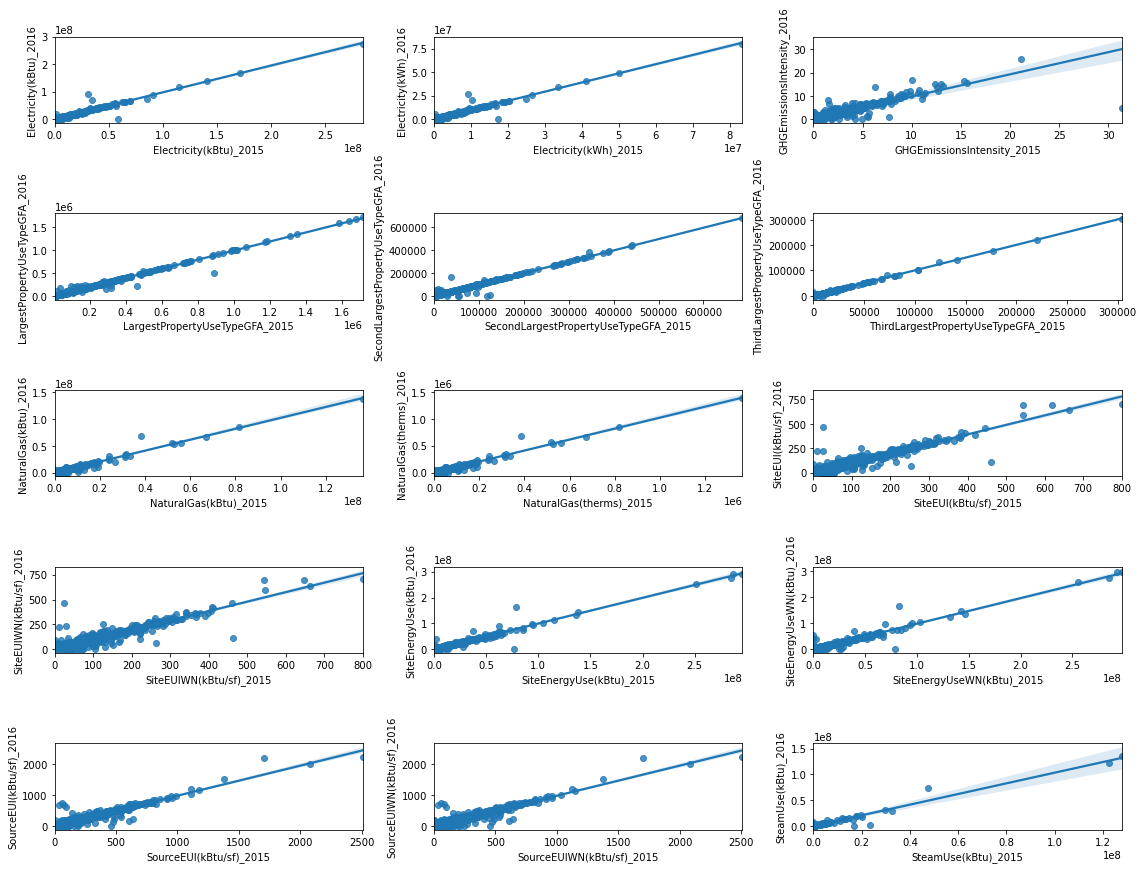

In [60]:
fig = plt.figure(figsize = (16,12))
for k in range(len(QuantVarCO2)):
    dataCO2.loc[dataCO2[QuantVarCO2[k][0]] < 0, QuantVarCO2[k][0]] = np.abs(dataCO2[dataCO2[QuantVarCO2[k][0]] < 0][QuantVarCO2[k][0]])
    dataCO2.loc[dataCO2[QuantVarCO2[k][1]] < 0, QuantVarCO2[k][1]] = np.abs(dataCO2[dataCO2[QuantVarCO2[k][1]] < 0][QuantVarCO2[k][1]])
    dataset = dataCO2[[QuantVarCO2[k][0], QuantVarCO2[k][1]]].dropna()
    ax = fig.add_subplot(5, 3, (k+1))
    sns.regplot(x=dataset[QuantVarCO2[k][0]], y=dataset[QuantVarCO2[k][1]])
    ax.set_xlabel(QuantVarCO2[k][0])
    ax.set_ylabel(QuantVarCO2[k][1])
plt.tight_layout()
plt.show()

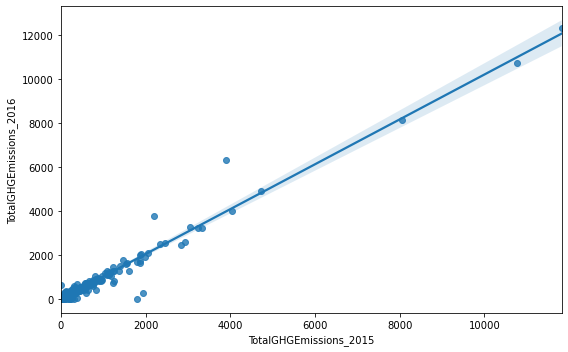

In [61]:
dataCTE.loc[dataCTE['TotalGHGEmissions_2015'] < 0, 'TotalGHGEmissions_2015'] = np.abs(dataCTE[dataCTE['TotalGHGEmissions_2015'] < 0]['TotalGHGEmissions_2015'])
dataCTE.loc[dataCTE['TotalGHGEmissions_2016'] < 0, 'TotalGHGEmissions_2016'] = np.abs(dataCTE[dataCTE['TotalGHGEmissions_2016'] < 0]['TotalGHGEmissions_2016'])
dataset = dataCTE[['TotalGHGEmissions_2015', 'TotalGHGEmissions_2016']].dropna()
fig = plt.figure(figsize = (8,5))
ax = fig.add_subplot()              
sns.regplot(x=dataset['TotalGHGEmissions_2015'], y=dataset['TotalGHGEmissions_2016'])
ax.set_xlabel('TotalGHGEmissions_2015')
ax.set_ylabel('TotalGHGEmissions_2016')
plt.tight_layout()
plt.show()

According to this figure, we can easily assume that there is a linear relationship for a given numerical variable between two consecutive years. So we are going to use linear regression to impute missing data for numeric features.

In [62]:
# Greenhouse gas emissions, including carbon dioxide

for k in range(15):
    dataCO2.loc[dataCO2[QuantVarCO2[k][0]] < 0, QuantVarCO2[k][0]] = np.abs(dataCO2[dataCO2[QuantVarCO2[k][0]] < 0][QuantVarCO2[k][0]])
    dataCO2.loc[dataCO2[QuantVarCO2[k][1]] < 0, QuantVarCO2[k][1]] = np.abs(dataCO2[dataCO2[QuantVarCO2[k][1]] < 0][QuantVarCO2[k][1]])
    if any(dataCO2[QuantVarCO2[k][1]].isna()):
        dataset = dataCO2[[QuantVarCO2[k][0], QuantVarCO2[k][1]]].dropna()
        X_2015 = dataset[[QuantVarCO2[k][0]]].values
        y_2016 = dataset[QuantVarCO2[k][1]].values
        model = LinearRegression()
        model.fit(X_2015, y_2016)
        dataCO2.loc[(dataCO2[QuantVarCO2[k][1]].isna()) & 
                    (~dataCO2[QuantVarCO2[k][0]].isna()), QuantVarCO2[k][1]] = model.predict(dataCO2[(dataCO2[QuantVarCO2[k][1]].isna()) &
                                                                                                  (~dataCO2[QuantVarCO2[k][0]].isna())][[QuantVarCO2[k][0]]])
    if any(dataCO2[QuantVarCO2[k][0]].isna()):
        dataset = dataCO2[[QuantVarCO2[k][0], QuantVarCO2[k][1]]].dropna()
        X_2016 = dataset[[QuantVarCO2[k][1]]].values
        y_2015 = dataset[QuantVarCO2[k][0]].values
        model2 = LinearRegression()
        model2.fit(X_2016, y_2015)
        dataCO2.loc[(dataCO2[QuantVarCO2[k][0]].isna()) & 
                    (~dataCO2[QuantVarCO2[k][1]].isna()), QuantVarCO2[k][0]] = model.predict(dataCO2[(dataCO2[QuantVarCO2[k][0]].isna()) & 
                                                                                                     (~dataCO2[QuantVarCO2[k][1]].isna())][[QuantVarCO2[k][1]]])

In [63]:
# Annual amount of energy consumed by the building

for k in range(15):
    dataCTE.loc[dataCTE[QuantVarCTE[k][0]] < 0, QuantVarCTE[k][0]] = np.abs(dataCTE[dataCTE[QuantVarCTE[k][0]] < 0][QuantVarCTE[k][0]])
    dataCTE.loc[dataCTE[QuantVarCTE[k][1]] < 0, QuantVarCTE[k][1]] = np.abs(dataCTE[dataCTE[QuantVarCTE[k][1]] < 0][QuantVarCTE[k][1]])
    if any(dataCTE[QuantVarCTE[k][1]].isna()):
        dataset = dataCTE[[QuantVarCTE[k][0], QuantVarCTE[k][1]]].dropna()
        X_2015 = dataset[[QuantVarCTE[k][0]]].values
        y_2016 = dataset[QuantVarCTE[k][1]].values
        model = LinearRegression()
        model.fit(X_2015, y_2016)
        dataCTE.loc[(dataCTE[QuantVarCTE[k][1]].isna()) & 
                    (~dataCTE[QuantVarCTE[k][0]].isna()), QuantVarCTE[k][1]] = model.predict(dataCTE[(dataCTE[QuantVarCTE[k][1]].isna()) &
                                                                                                  (~dataCTE[QuantVarCTE[k][0]].isna())][[QuantVarCTE[k][0]]])
    if any(dataCTE[QuantVarCTE[k][0]].isna()):
        dataset = dataCTE[[QuantVarCTE[k][0], QuantVarCTE[k][1]]].dropna()
        X_2016 = dataset[[QuantVarCTE[k][1]]].values
        y_2015 = dataset[QuantVarCTE[k][0]].values
        model2 = LinearRegression()
        model2.fit(X_2016, y_2015)
        dataCTE.loc[(dataCTE[QuantVarCTE[k][0]].isna()) & 
                    (~dataCTE[QuantVarCTE[k][1]].isna()), QuantVarCTE[k][0]] = model.predict(dataCTE[(dataCTE[QuantVarCTE[k][0]].isna()) & 
                                                                                                     (~dataCTE[QuantVarCTE[k][1]].isna())][[QuantVarCTE[k][1]]])

In [64]:
# Greenhouse gas emissions, including carbon dioxide
numericVarCO2 = dataCO2.select_dtypes(np.number).columns.tolist()
numericVarCO2.remove('ENERGYSTARScore_2015')
numericVarCO2.remove('ENERGYSTARScore_2016')
numericVarCO2.remove('TotalGHGEmissions_2015')
numericVarCO2.remove('TotalGHGEmissions_2016')

# Annual amount of energy consumed by the building
numericVarCTE = dataCTE.select_dtypes(np.number).columns.tolist()
numericVarCTE.remove('ENERGYSTARScore_2015')
numericVarCTE.remove('ENERGYSTARScore_2016')
numericVarCTE.remove('SiteEnergyUse(kBtu)_2015')
numericVarCTE.remove('SiteEnergyUse(kBtu)_2016')

In [65]:
# Missing values imputation for some numerical features

VarNotToImpute = ['LargestPropertyUseTypeGFA_2015', 'LargestPropertyUseTypeGFA_2016', 
                  'SecondLargestPropertyUseTypeGFA_2015', 'SecondLargestPropertyUseTypeGFA_2016',
                  'ThirdLargestPropertyUseTypeGFA_2015', 'ThirdLargestPropertyUseTypeGFA_2016',
                  'PropertyGFATotal_2015', 'PropertyGFATotal_2016', 'PropertyGFAParking_2015', 
                  'PropertyGFAParking_2015','PropertyGFABuilding(s)_2015', 'PropertyGFABuilding(s)_2015']
ImpNumericVarCO2 = [feat for feat in numericVarCO2 if feat not in VarNotToImpute]
ImpNumericVarCTE = [feat for feat in numericVarCTE if feat not in VarNotToImpute]

imputer = SimpleImputer(strategy='median') # We will impute all the missing values by the median of the feature because of the presence of outliers
dataCO2[ImpNumericVarCO2] = imputer.fit_transform(dataCO2[ImpNumericVarCO2])
dataCTE[ImpNumericVarCTE] = imputer.fit_transform(dataCTE[ImpNumericVarCTE])

In [66]:
logVarQCO2 = ['Log' + x for x in VarQCO2]
dataCO2[VarQCO2] = np.abs(dataCO2[VarQCO2])
dataCO2[logVarQCO2] = np.log1p(dataCO2[VarQCO2])
dataCO2.drop(VarQCO2, axis = 1, inplace = True)

In [67]:
logVarQCTE = ['Log' + x for x in VarQCTE]
dataCTE[VarQCTE] = np.abs(dataCTE[VarQCTE])
dataCTE[logVarQCTE] = np.log1p(dataCTE[VarQCTE])
dataCTE.drop(VarQCTE, axis = 1, inplace = True)

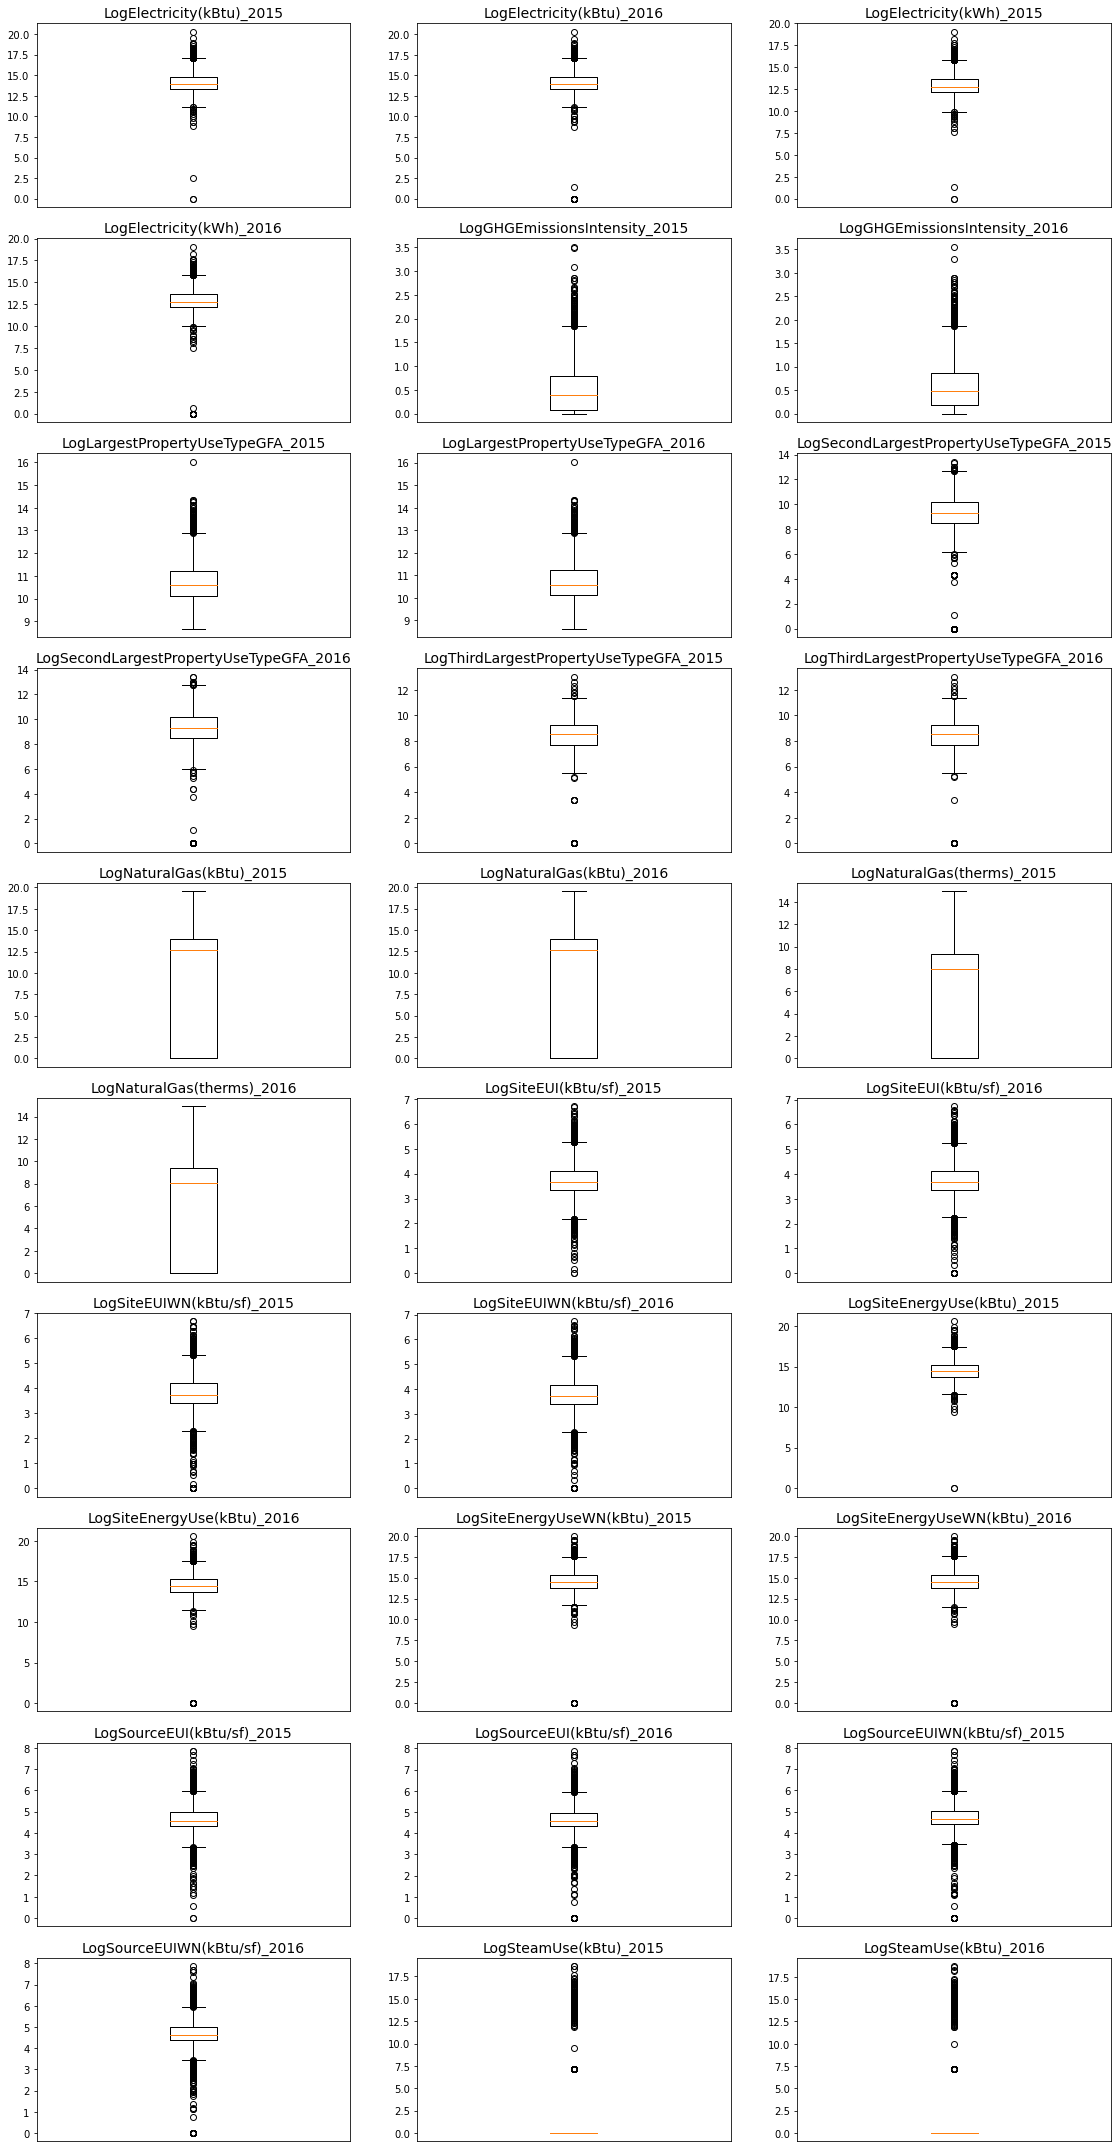

In [68]:
# Distribution des varaibles quantitatives

fig = plt.figure(figsize = (16,30))
#fig = plt.figure()
for k in range(len(logVarQCO2)):
    ax = fig.add_subplot(10, 3, (k+1))
    h = ax.boxplot(dataCO2.loc[dataCO2[logVarQCO2[k]].notna(), logVarQCO2[k]])
    ax.set_title(logVarQCO2[k], fontsize = 14)
    ax.set_xticks([])
    ax.set_xticklabels('')
plt.tight_layout()

#### Categorize some features to capture the NaN's effects

Due to the large quantity of missing values for some numerical features, we are going to categorize them in order to capture the missing values effects.

- LargestPropertyUseTypeGFA

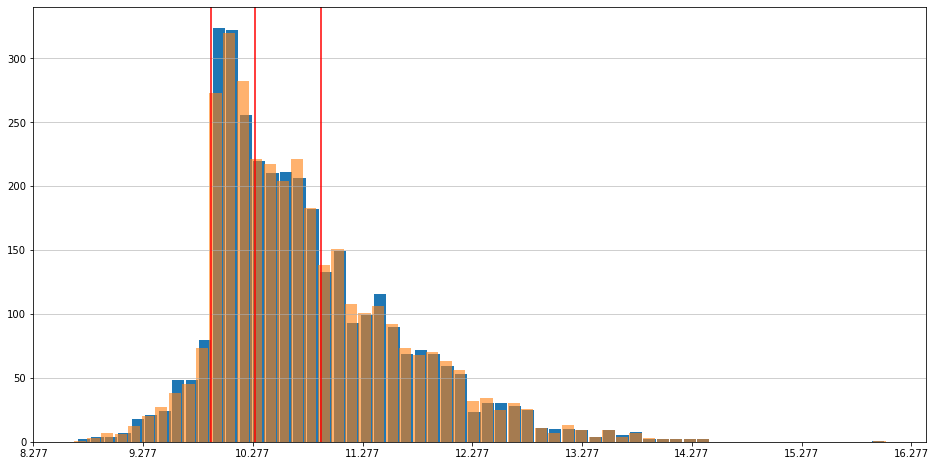

In [69]:
VarListCat = [('LogLargestPropertyUseTypeGFA_2015', 'LogLargestPropertyUseTypeGFA_2016')]

for var in VarListCat:
    dt1 = dataCO2.loc[dataCO2[var[0]].notna(), var[0]]
    dt2 = dataCO2.loc[dataCO2[var[1]].notna(), var[1]]
    fig, ax = plt.subplots(figsize = (16,8))
    ax.hist(dt1, bins=60, rwidth=0.9)
    ax.hist(dt2, bins=60, alpha=0.6, rwidth=0.9)
    plt.axvline(x=9.9, color = 'red')
    plt.axvline(x=10.3, color = 'red')
    plt.axvline(x=10.9, color = 'red')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 1))
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(axis='y', alpha=0.75)

In [70]:
#CO2
dataCO2['LargestPropertyUseTypeGFACat_2015'] = np.where(
    dataCO2['LogLargestPropertyUseTypeGFA_2015'].isna(), 'G5',
    np.where((dataCO2['LogLargestPropertyUseTypeGFA_2015']<9.9), 'G1',
             np.where(dataCO2['LogLargestPropertyUseTypeGFA_2015']<10.3, 'G2',
                      np.where(dataCO2['LogLargestPropertyUseTypeGFA_2015']<10.9, 'G3','G4'))))

dataCO2['LargestPropertyUseTypeGFACat_2016'] = np.where(
    dataCO2['LogLargestPropertyUseTypeGFA_2016'].isna(), 'G5',
    np.where((dataCO2['LogLargestPropertyUseTypeGFA_2016']<9.9), 'G1',
             np.where(dataCO2['LogLargestPropertyUseTypeGFA_2016']<10.3, 'G2',
                      np.where(dataCO2['LogLargestPropertyUseTypeGFA_2016']<10.9, 'G3','G4'))))

dataCO2.drop(['LogLargestPropertyUseTypeGFA_2015', 'LogLargestPropertyUseTypeGFA_2016'], axis = 1, inplace = True)

#CTE
dataCTE['LargestPropertyUseTypeGFACat_2015'] = np.where(
    dataCTE['LogLargestPropertyUseTypeGFA_2015'].isna(), 'G5',
    np.where((dataCTE['LogLargestPropertyUseTypeGFA_2015']<9.9), 'G1',
             np.where(dataCTE['LogLargestPropertyUseTypeGFA_2015']<10.3, 'G2',
                      np.where(dataCTE['LogLargestPropertyUseTypeGFA_2015']<10.9, 'G3','G4'))))

dataCTE['LargestPropertyUseTypeGFACat_2016'] = np.where(
    dataCTE['LogLargestPropertyUseTypeGFA_2016'].isna(), 'G5',
    np.where((dataCTE['LogLargestPropertyUseTypeGFA_2016']<9.9), 'G1',
             np.where(dataCTE['LogLargestPropertyUseTypeGFA_2016']<10.3, 'G2',
                      np.where(dataCTE['LogLargestPropertyUseTypeGFA_2016']<10.9, 'G3','G4'))))

dataCTE.drop(['LogLargestPropertyUseTypeGFA_2015', 'LogLargestPropertyUseTypeGFA_2016'], axis = 1, inplace = True)

Text(0.5, 1.0, 'LargestPropertyUseTypeGFACat_2016')

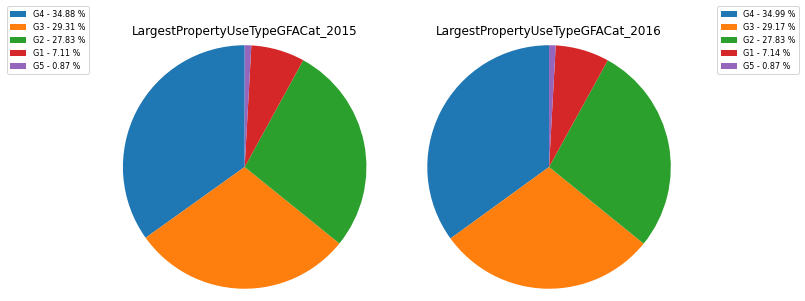

In [71]:
labels2015 = dataCO2['LargestPropertyUseTypeGFACat_2015'].value_counts().index
sizes2015 = dataCO2['LargestPropertyUseTypeGFACat_2015'].value_counts().values
porcent2015 = 100.*sizes2015/sizes2015.sum()

labels2016 = dataCO2['LargestPropertyUseTypeGFACat_2016'].value_counts().index
sizes2016 = dataCO2['LargestPropertyUseTypeGFACat_2016'].value_counts().values
porcent2016 = 100.*sizes2016/sizes2016.sum()

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
patches, texts = plt.pie(sizes2015, startangle=90, radius=1.2)
lb2015 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels2015, porcent2015)]

sort_legend = True

if sort_legend:
    patches, lb2015, dummy =  zip(*sorted(zip(patches, lb2015, sizes2015),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, lb2015, loc='center right', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
plt.title('LargestPropertyUseTypeGFACat_2015')


plt.subplot(1,2,2)
patches, texts = plt.pie(sizes2016, startangle=90, radius=1.2)
lb2016 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels2016, porcent2016)]

sort_legend = True

if sort_legend:
    patches, lb2016, dummy =  zip(*sorted(zip(patches, lb2016, sizes2016),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, lb2016, loc='center right', bbox_to_anchor=(1.5, 1.),
           fontsize=8)
plt.title('LargestPropertyUseTypeGFACat_2016')

- SecondLargestPropertyUseTypeGFA

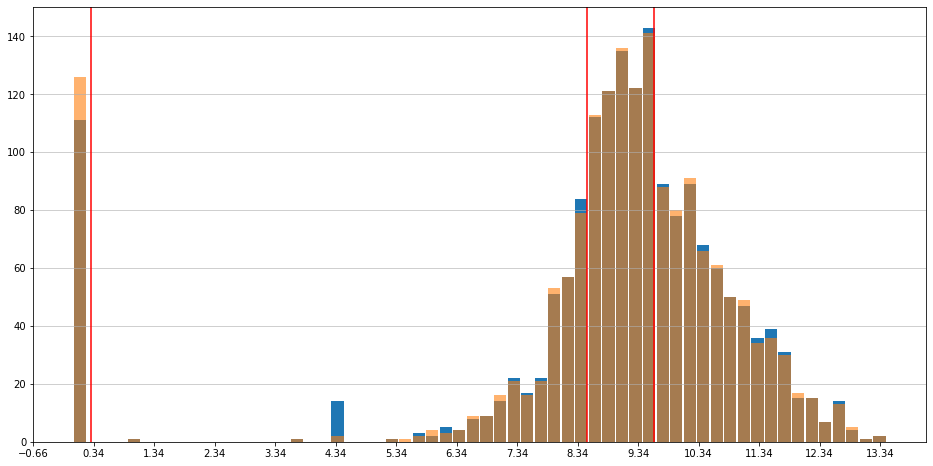

In [72]:
VarListCat = [('LogSecondLargestPropertyUseTypeGFA_2015', 'LogSecondLargestPropertyUseTypeGFA_2016')]

for var in VarListCat:
    dt1 = dataCO2.loc[dataCO2[var[0]].notna(), var[0]]
    dt2 = dataCO2.loc[dataCO2[var[1]].notna(), var[1]]
    fig, ax = plt.subplots(figsize = (16,8))
    ax.hist(dt1, bins=60, rwidth=0.9)
    ax.hist(dt2, bins=60, alpha=0.6, rwidth=0.9)
    plt.axvline(x=0.3, color = 'red')
    plt.axvline(x=8.5, color = 'red')
    plt.axvline(x=9.6, color = 'red')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 1))
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(axis='y', alpha=0.75)

In [73]:
#CO2
dataCO2['SecondLargestPropertyUseTypeGFACat_2015'] = np.where(
    dataCO2['LogSecondLargestPropertyUseTypeGFA_2015'].isna(), 'G5',
    np.where((dataCO2['LogSecondLargestPropertyUseTypeGFA_2015']<0.3), 'G1',
             np.where(dataCO2['LogSecondLargestPropertyUseTypeGFA_2015']<8.5, 'G2',
                      np.where(dataCO2['LogSecondLargestPropertyUseTypeGFA_2015']<9.6, 'G3','G4'))))

dataCO2['SecondLargestPropertyUseTypeGFACat_2016'] = np.where(
    dataCO2['LogSecondLargestPropertyUseTypeGFA_2016'].isna(), 'G5',
    np.where((dataCO2['LogSecondLargestPropertyUseTypeGFA_2016']<0.3), 'G1',
             np.where(dataCO2['LogSecondLargestPropertyUseTypeGFA_2016']<8.5, 'G2',
                      np.where(dataCO2['LogSecondLargestPropertyUseTypeGFA_2016']<9.6, 'G3','G4'))))

dataCO2.drop(['LogSecondLargestPropertyUseTypeGFA_2015', 'LogSecondLargestPropertyUseTypeGFA_2016'], axis = 1, inplace = True)

#CTE
dataCTE['SecondLargestPropertyUseTypeGFACat_2015'] = np.where(
    dataCTE['LogSecondLargestPropertyUseTypeGFA_2015'].isna(), 'G5',
    np.where((dataCTE['LogSecondLargestPropertyUseTypeGFA_2015']<0.3), 'G1',
             np.where(dataCTE['LogSecondLargestPropertyUseTypeGFA_2015']<8.5, 'G2',
                      np.where(dataCTE['LogSecondLargestPropertyUseTypeGFA_2015']<9.6, 'G3','G4'))))

dataCTE['SecondLargestPropertyUseTypeGFACat_2016'] = np.where(
    dataCTE['LogSecondLargestPropertyUseTypeGFA_2016'].isna(), 'G5',
    np.where((dataCTE['LogSecondLargestPropertyUseTypeGFA_2016']<0.3), 'G1',
             np.where(dataCTE['LogSecondLargestPropertyUseTypeGFA_2016']<8.5, 'G2',
                      np.where(dataCTE['LogSecondLargestPropertyUseTypeGFA_2016']<9.6, 'G3','G4'))))

dataCTE.drop(['LogSecondLargestPropertyUseTypeGFA_2015', 'LogSecondLargestPropertyUseTypeGFA_2016'], axis = 1, inplace = True)

Text(0.5, 1.0, 'SecondLargestPropertyUseTypeGFACat_2016')

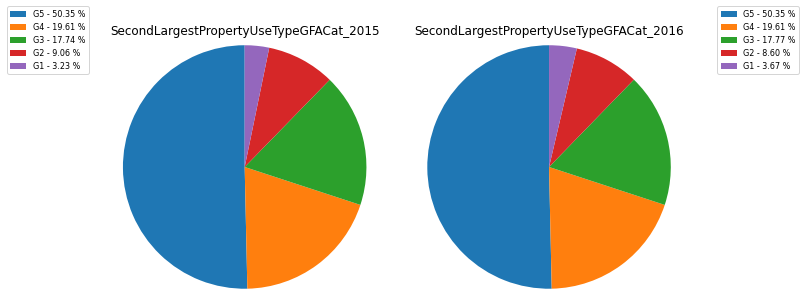

In [74]:
labels2015 = dataCO2['SecondLargestPropertyUseTypeGFACat_2015'].value_counts().index
sizes2015 = dataCO2['SecondLargestPropertyUseTypeGFACat_2015'].value_counts().values
porcent2015 = 100.*sizes2015/sizes2015.sum()

labels2016 = dataCO2['SecondLargestPropertyUseTypeGFACat_2016'].value_counts().index
sizes2016 = dataCO2['SecondLargestPropertyUseTypeGFACat_2016'].value_counts().values
porcent2016 = 100.*sizes2016/sizes2016.sum()

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
patches, texts = plt.pie(sizes2015, startangle=90, radius=1.2)
lb2015 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels2015, porcent2015)]

sort_legend = True

if sort_legend:
    patches, lb2015, dummy =  zip(*sorted(zip(patches, lb2015, sizes2015),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, lb2015, loc='center right', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
plt.title('SecondLargestPropertyUseTypeGFACat_2015')


plt.subplot(1,2,2)
patches, texts = plt.pie(sizes2016, startangle=90, radius=1.2)
lb2016 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels2016, porcent2016)]

sort_legend = True

if sort_legend:
    patches, lb2016, dummy =  zip(*sorted(zip(patches, lb2016, sizes2016),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, lb2016, loc='center right', bbox_to_anchor=(1.5, 1.),
           fontsize=8)
plt.title('SecondLargestPropertyUseTypeGFACat_2016')

- ThirdLargestPropertyUseTypeGFA

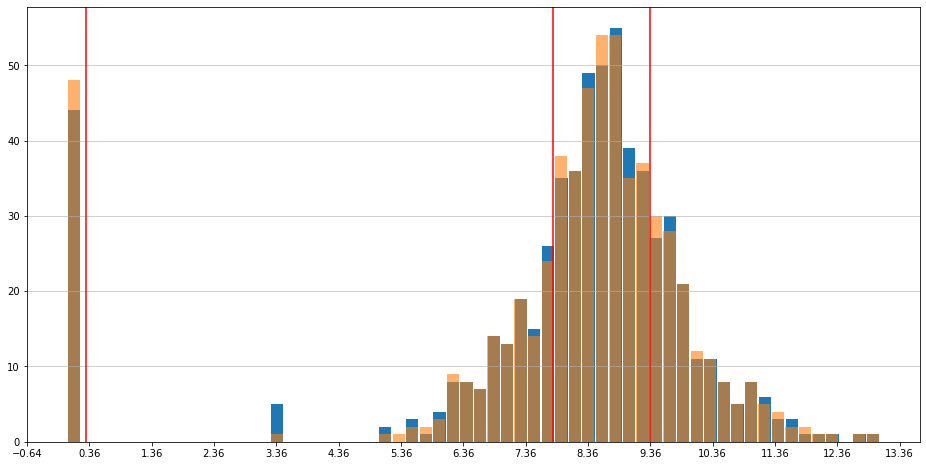

In [75]:
VarListCat = [('LogThirdLargestPropertyUseTypeGFA_2015', 'LogThirdLargestPropertyUseTypeGFA_2016')]

for var in VarListCat:
    dt1 = dataCO2.loc[dataCO2[var[0]].notna(), var[0]]
    dt2 = dataCO2.loc[dataCO2[var[1]].notna(), var[1]]
    fig, ax = plt.subplots(figsize = (16,8))
    ax.hist(dt1, bins=60, rwidth=0.9)
    ax.hist(dt2, bins=60, alpha=0.6, rwidth=0.9)
    plt.axvline(x=0.3, color = 'red')
    plt.axvline(x=7.8, color = 'red')
    plt.axvline(x=9.36, color = 'red')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 1))
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(axis='y', alpha=0.75)

In [76]:
#CO2
dataCO2['ThirdLargestPropertyUseTypeGFACat_2015'] = np.where(
    dataCO2['LogThirdLargestPropertyUseTypeGFA_2015'].isna(), 'G5',
    np.where((dataCO2['LogThirdLargestPropertyUseTypeGFA_2015']<0.3), 'G1',
             np.where(dataCO2['LogThirdLargestPropertyUseTypeGFA_2015']<7.8, 'G2',
                      np.where(dataCO2['LogThirdLargestPropertyUseTypeGFA_2015']<9.36, 'G3','G4'))))

dataCO2['ThirdLargestPropertyUseTypeGFACat_2016'] = np.where(
    dataCO2['LogThirdLargestPropertyUseTypeGFA_2016'].isna(), 'G5',
    np.where((dataCO2['LogThirdLargestPropertyUseTypeGFA_2016']<0.3), 'G1',
             np.where(dataCO2['LogThirdLargestPropertyUseTypeGFA_2016']<7.8, 'G2',
                      np.where(dataCO2['LogThirdLargestPropertyUseTypeGFA_2016']<9.36, 'G3','G4'))))

dataCO2.drop(['LogThirdLargestPropertyUseTypeGFA_2015', 'LogThirdLargestPropertyUseTypeGFA_2016'], axis = 1, inplace = True)

#CTE
dataCTE['ThirdLargestPropertyUseTypeGFACat_2015'] = np.where(
    dataCTE['LogThirdLargestPropertyUseTypeGFA_2015'].isna(), 'G5',
    np.where((dataCTE['LogThirdLargestPropertyUseTypeGFA_2015']<0.3), 'G1',
             np.where(dataCTE['LogThirdLargestPropertyUseTypeGFA_2015']<7.8, 'G2',
                      np.where(dataCTE['LogThirdLargestPropertyUseTypeGFA_2015']<9.36, 'G3','G4'))))

dataCTE['ThirdLargestPropertyUseTypeGFACat_2016'] = np.where(
    dataCTE['LogThirdLargestPropertyUseTypeGFA_2016'].isna(), 'G5',
    np.where((dataCTE['LogThirdLargestPropertyUseTypeGFA_2016']<0.3), 'G1',
             np.where(dataCTE['LogThirdLargestPropertyUseTypeGFA_2016']<7.8, 'G2',
                      np.where(dataCTE['LogThirdLargestPropertyUseTypeGFA_2016']<9.36, 'G3','G4'))))

dataCTE.drop(['LogThirdLargestPropertyUseTypeGFA_2015', 'LogThirdLargestPropertyUseTypeGFA_2016'], axis = 1, inplace = True)

Text(0.5, 1.0, 'ThirdLargestPropertyUseTypeGFACat_2016')

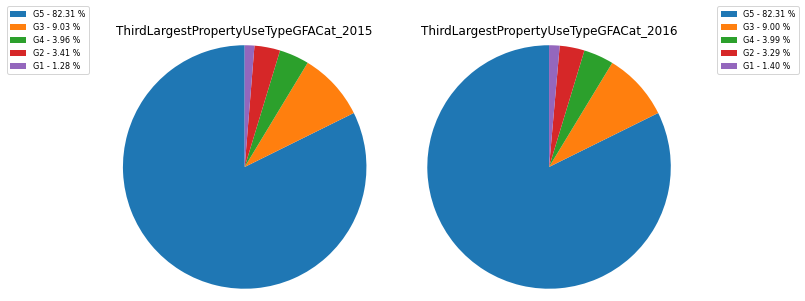

In [77]:
labels2015 = dataCO2['ThirdLargestPropertyUseTypeGFACat_2015'].value_counts().index
sizes2015 = dataCO2['ThirdLargestPropertyUseTypeGFACat_2015'].value_counts().values
porcent2015 = 100.*sizes2015/sizes2015.sum()

labels2016 = dataCO2['ThirdLargestPropertyUseTypeGFACat_2016'].value_counts().index
sizes2016 = dataCO2['ThirdLargestPropertyUseTypeGFACat_2016'].value_counts().values
porcent2016 = 100.*sizes2016/sizes2016.sum()

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
patches, texts = plt.pie(sizes2015, startangle=90, radius=1.2)
lb2015 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels2015, porcent2015)]

sort_legend = True

if sort_legend:
    patches, lb2015, dummy =  zip(*sorted(zip(patches, lb2015, sizes2015),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, lb2015, loc='center right', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
plt.title('ThirdLargestPropertyUseTypeGFACat_2015')


plt.subplot(1,2,2)
patches, texts = plt.pie(sizes2016, startangle=90, radius=1.2)
lb2016 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels2016, porcent2016)]

sort_legend = True

if sort_legend:
    patches, lb2016, dummy =  zip(*sorted(zip(patches, lb2016, sizes2016),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, lb2016, loc='center right', bbox_to_anchor=(1.5, 1.),
           fontsize=8)
plt.title('ThirdLargestPropertyUseTypeGFACat_2016')

- PropertyGFATotal

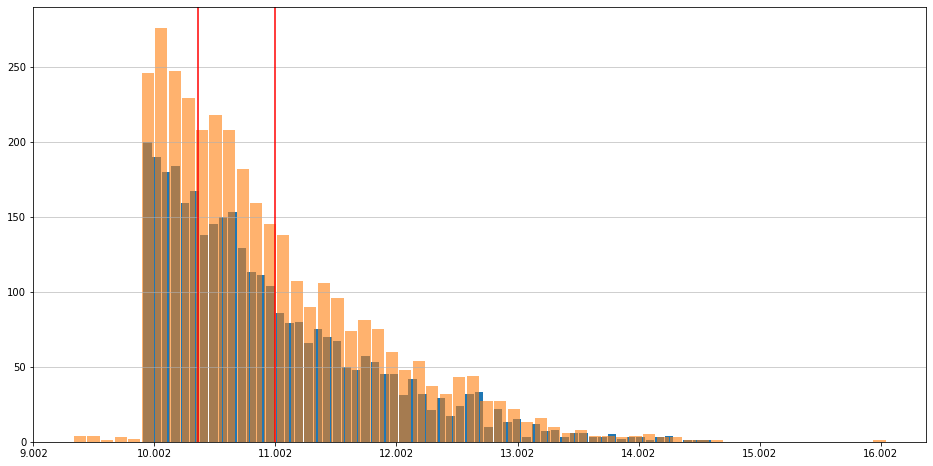

In [78]:
VarListCat = [('PropertyGFATotal_2015', 'PropertyGFATotal_2016')]

for var in VarListCat:
    dt1 = np.log1p(dataCO2.loc[dataCO2[var[0]].notna(), var[0]])
    dt2 = np.log1p(dataCO2.loc[dataCO2[var[1]].notna(), var[1]])
    fig, ax = plt.subplots(figsize = (16,8))
    ax.hist(dt1, bins=60, rwidth=0.9)
    ax.hist(dt2, bins=60, alpha=0.6, rwidth=0.9)
    plt.axvline(x=10.36, color = 'red')
    plt.axvline(x=11, color = 'red')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 1))
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(axis='y', alpha=0.75)

In [79]:
#CO2
dataCO2['PropertyGFATotalCat_2015'] = np.where(
    dataCO2['PropertyGFATotal_2015'].isna(), 'G5',
    np.where((np.log1p(dataCO2['PropertyGFATotal_2015'])<10.36), 'G1',
             np.where(np.log1p(dataCO2['PropertyGFATotal_2015'])<11, 'G3','G4')))

dataCO2['PropertyGFATotalCat_2016'] = np.where(
    dataCO2['PropertyGFATotal_2016'].isna(), 'G4',
    np.where((np.log1p(dataCO2['PropertyGFATotal_2016'])<10.36), 'G1',
             np.where(np.log1p(dataCO2['PropertyGFATotal_2016'])<11, 'G2','G3')))

dataCO2.drop(['PropertyGFATotal_2015', 'PropertyGFATotal_2016'], axis = 1, inplace = True)

#CTE
dataCTE['PropertyGFATotalCat_2015'] = np.where(
    dataCTE['PropertyGFATotal_2015'].isna(), 'G5',
    np.where((np.log1p(dataCTE['PropertyGFATotal_2015'])<10.36), 'G1',
             np.where(np.log1p(dataCTE['PropertyGFATotal_2015']+1)<11, 'G3','G4')))

dataCTE['PropertyGFATotalCat_2016'] = np.where(
    dataCTE['PropertyGFATotal_2016'].isna(), 'G4',
    np.where((np.log1p(dataCTE['PropertyGFATotal_2016'])<10.36), 'G1',
             np.where(np.log1p(dataCTE['PropertyGFATotal_2016'])<11, 'G2','G3')))

dataCTE.drop(['PropertyGFATotal_2015', 'PropertyGFATotal_2016'], axis = 1, inplace = True)

Text(0.5, 1.0, 'PropertyGFATotalCat_2016')

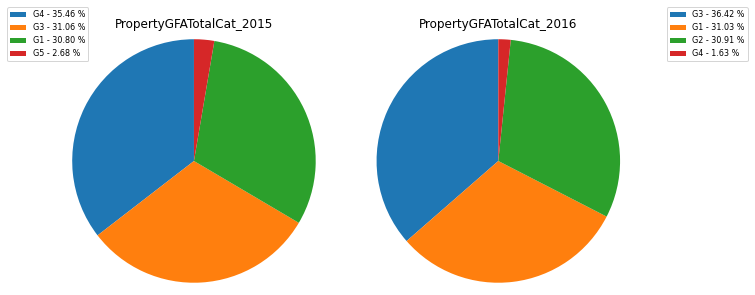

In [80]:
labels2015 = dataCO2['PropertyGFATotalCat_2015'].value_counts().index
sizes2015 = dataCO2['PropertyGFATotalCat_2015'].value_counts().values
porcent2015 = 100.*sizes2015/sizes2015.sum()

labels2016 = dataCO2['PropertyGFATotalCat_2016'].value_counts().index
sizes2016 = dataCO2['PropertyGFATotalCat_2016'].value_counts().values
porcent2016 = 100.*sizes2016/sizes2016.sum()

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
patches, texts = plt.pie(sizes2015, startangle=90, radius=1.2)
lb2015 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels2015, porcent2015)]

sort_legend = True

if sort_legend:
    patches, lb2015, dummy =  zip(*sorted(zip(patches, lb2015, sizes2015),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, lb2015, loc='center right', bbox_to_anchor=(0.1, 1.),
           fontsize=8)
plt.title('PropertyGFATotalCat_2015')


plt.subplot(1,2,2)
patches, texts = plt.pie(sizes2016, startangle=90, radius=1.2)
lb2016 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels2016, porcent2016)]

sort_legend = True

if sort_legend:
    patches, lb2016, dummy =  zip(*sorted(zip(patches, lb2016, sizes2016),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, lb2016, loc='center right', bbox_to_anchor=(1.5, 1.),
           fontsize=8)
plt.title('PropertyGFATotalCat_2016')

- PropertyGFAParking

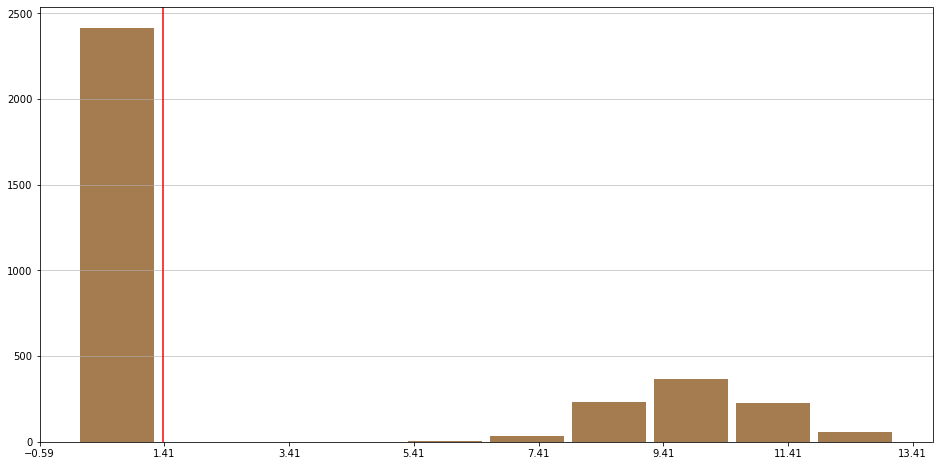

In [81]:
VarListCat = [('PropertyGFAParking_2015', 'PropertyGFAParking_2015')]

for var in VarListCat:
    dt1 = np.log1p(dataCO2.loc[data[var[0]].notna(), var[0]])
    dt2 = np.log1p(dataCO2.loc[data[var[1]].notna(), var[1]])
    fig, ax = plt.subplots(figsize = (16,8))
    ax.hist(dt1, bins=10, rwidth=0.9)
    ax.hist(dt2, bins=10, alpha=0.6, rwidth=0.9)
    plt.axvline(x=1.4, color = 'red')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 2))
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(axis='y', alpha=0.75)

In [82]:
#CO2
dataCO2['PropertyGFAParkingCat_2015'] = np.where(
    dataCO2['PropertyGFAParking_2015'].isna(), 'G3',
    np.where(np.log1p(dataCO2['PropertyGFAParking_2015'])<1.4, 'G1','G2'))

dataCO2['PropertyGFAParkingCat_2016'] = np.where(
    dataCO2['PropertyGFAParking_2016'].isna(), 'G3',
    np.where(np.log1p(dataCO2['PropertyGFAParking_2016'])<1.4, 'G1','G2'))

dataCO2.drop(['PropertyGFAParking_2015', 'PropertyGFAParking_2016'], axis = 1, inplace = True)

#CTE
dataCTE['PropertyGFAParkingCat_2015'] = np.where(
    dataCTE['PropertyGFAParking_2015'].isna(), 'G3',
    np.where(np.log1p(dataCTE['PropertyGFAParking_2015'])<1.4, 'G1','G2'))

dataCTE['PropertyGFAParkingCat_2016'] = np.where(
    dataCTE['PropertyGFAParking_2016'].isna(), 'G3',
    np.where(np.log1p(dataCTE['PropertyGFAParking_2016'])<1.4, 'G1','G2'))

dataCTE.drop(['PropertyGFAParking_2015', 'PropertyGFAParking_2016'], axis = 1, inplace = True)

Text(0.5, 1.0, 'PropertyGFAParkingCat_2016')

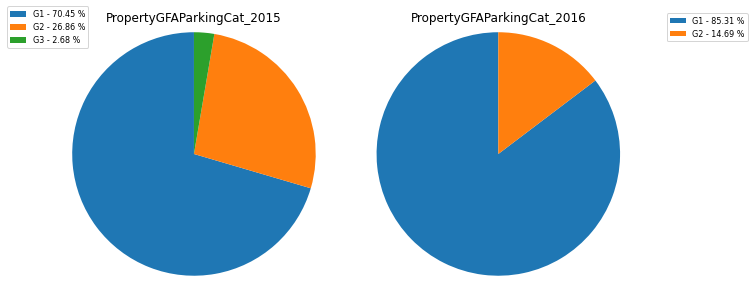

In [83]:
labels2015 = dataCO2['PropertyGFAParkingCat_2015'].value_counts().index
sizes2015 = dataCO2['PropertyGFAParkingCat_2015'].value_counts().values
porcent2015 = 100.*sizes2015/sizes2015.sum()

labels2016 = dataCO2['PropertyGFAParkingCat_2016'].value_counts().index
sizes2016 = dataCO2['PropertyGFAParkingCat_2016'].value_counts().values
porcent2016 = 100.*sizes2016/sizes2016.sum()

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
patches, texts = plt.pie(sizes2015, startangle=90, radius=1.2)
lb2015 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels2015, porcent2015)]

sort_legend = True

if sort_legend:
    patches, lb2015, dummy =  zip(*sorted(zip(patches, lb2015, sizes2015),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, lb2015, loc='center right', bbox_to_anchor=(0.1, 1.),
           fontsize=8)
plt.title('PropertyGFAParkingCat_2015')


plt.subplot(1,2,2)
patches, texts = plt.pie(sizes2016, startangle=90, radius=1.2)
lb2016 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels2016, porcent2016)]

sort_legend = True

if sort_legend:
    patches, lb2016, dummy =  zip(*sorted(zip(patches, lb2016, sizes2016),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, lb2016, loc='center right', bbox_to_anchor=(1.5, 1.),
           fontsize=8)
plt.title('PropertyGFAParkingCat_2016')

- PropertyGFABuilding(s)

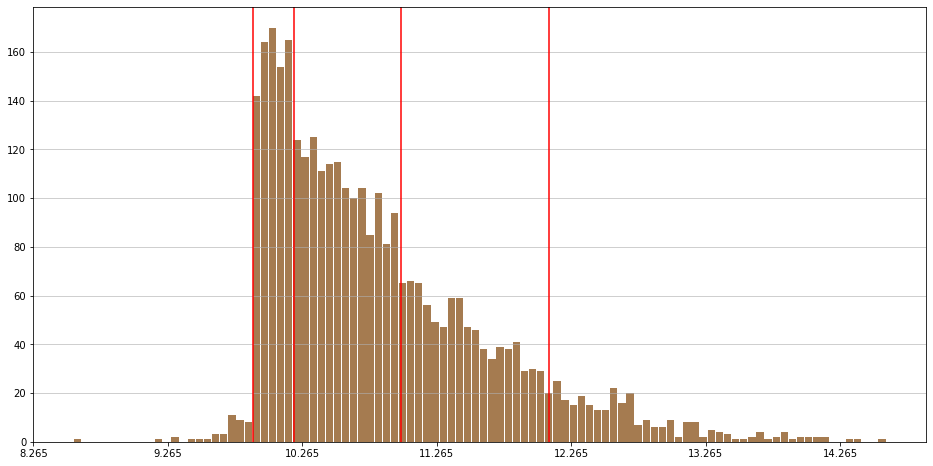

In [84]:
VarListCat = [('PropertyGFABuilding(s)_2015', 'PropertyGFABuilding(s)_2015')]

for var in VarListCat:
    dt1 = np.log1p(dataCO2.loc[data[var[0]].notna(), var[0]])
    dt2 = np.log1p(dataCO2.loc[data[var[1]].notna(), var[1]])
    fig, ax = plt.subplots(figsize = (16,8))
    ax.hist(dt1, bins=100, rwidth=0.9)
    ax.hist(dt2, bins=100, alpha=0.6, rwidth=0.9)
    plt.axvline(x=9.9, color = 'red')
    plt.axvline(x=10.2, color = 'red')
    plt.axvline(x=11, color = 'red')
    plt.axvline(x=12.1, color = 'red')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 1))
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(axis='y', alpha=0.75)

In [85]:
#CO2
dataCO2['PropertyGFABuilding(s)Cat_2015'] = np.where(
    dataCO2['PropertyGFABuilding(s)_2015'].isna(), 'G6',
    np.where((np.log1p(dataCO2['PropertyGFABuilding(s)_2015'])<9.9), 'G1',
             np.where((np.log1p(dataCO2['PropertyGFABuilding(s)_2015'])<10.2), 'G2',
                      np.where((np.log1p(dataCO2['PropertyGFABuilding(s)_2015'])<11), 'G3',
                               np.where(np.log1p(dataCO2['PropertyGFABuilding(s)_2015'])<12.1, 'G4','G5')))))

dataCO2['PropertyGFABuilding(s)Cat_2016'] = np.where(
    dataCO2['PropertyGFABuilding(s)_2016'].isna(), 'G6',
    np.where((np.log1p(dataCO2['PropertyGFABuilding(s)_2016'])<9.9), 'G1',
             np.where((np.log1p(dataCO2['PropertyGFABuilding(s)_2016'])<10.2), 'G2',
                      np.where((np.log1p(dataCO2['PropertyGFABuilding(s)_2016'])<11), 'G3',
                               np.where(np.log1p(dataCO2['PropertyGFABuilding(s)_2016'])<12.1, 'G4','G5')))))

dataCO2.drop(['PropertyGFABuilding(s)_2015', 'PropertyGFABuilding(s)_2016'], axis = 1, inplace = True)

#CTE
dataCTE['PropertyGFABuilding(s)Cat_2015'] = np.where(
    dataCTE['PropertyGFABuilding(s)_2015'].isna(), 'G6',
    np.where((np.log1p(dataCTE['PropertyGFABuilding(s)_2015']+1)<9.9), 'G1',
             np.where((np.log1p(dataCTE['PropertyGFABuilding(s)_2015'])<10.2), 'G2',
                      np.where((np.log1p(dataCTE['PropertyGFABuilding(s)_2015'])<11), 'G3',
                               np.where(np.log1p(dataCTE['PropertyGFABuilding(s)_2015'])<12.1, 'G4','G5')))))

dataCTE['PropertyGFABuilding(s)Cat_2016'] = np.where(
    dataCTE['PropertyGFABuilding(s)_2016'].isna(), 'G6',
    np.where((np.log1p(dataCTE['PropertyGFABuilding(s)_2016'])<9.9), 'G1',
             np.where((np.log1p(dataCTE['PropertyGFABuilding(s)_2016'])<10.2), 'G2',
                      np.where((np.log1p(dataCTE['PropertyGFABuilding(s)_2016'])<11), 'G3',
                               np.where(np.log1p(dataCTE['PropertyGFABuilding(s)_2016'])<12.1, 'G4','G5')))))

dataCTE.drop(['PropertyGFABuilding(s)_2015', 'PropertyGFABuilding(s)_2016'], axis = 1, inplace = True)

Text(0.5, 1.0, 'PropertyGFABuilding(s)Cat_2016')

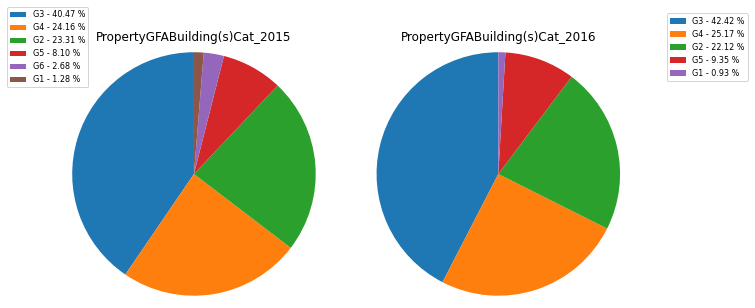

In [86]:
labels2015 = dataCO2['PropertyGFABuilding(s)Cat_2015'].value_counts().index
sizes2015 = dataCO2['PropertyGFABuilding(s)Cat_2015'].value_counts().values
porcent2015 = 100.*sizes2015/sizes2015.sum()

labels2016 = dataCO2['PropertyGFABuilding(s)Cat_2016'].value_counts().index
sizes2016 = dataCO2['PropertyGFABuilding(s)Cat_2016'].value_counts().values
porcent2016 = 100.*sizes2016/sizes2016.sum()

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
patches, texts = plt.pie(sizes2015, startangle=90, radius=1.2)
lb2015 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels2015, porcent2015)]

sort_legend = True

if sort_legend:
    patches, lb2015, dummy =  zip(*sorted(zip(patches, lb2015, sizes2015),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, lb2015, loc='center right', bbox_to_anchor=(0.1, 1.),
           fontsize=8)
plt.title('PropertyGFABuilding(s)Cat_2015')


plt.subplot(1,2,2)
patches, texts = plt.pie(sizes2016, startangle=90, radius=1.2)
lb2016 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels2016, porcent2016)]

sort_legend = True

if sort_legend:
    patches, lb2016, dummy =  zip(*sorted(zip(patches, lb2016, sizes2016),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, lb2016, loc='center right', bbox_to_anchor=(1.5, 1.),
           fontsize=8)
plt.title('PropertyGFABuilding(s)Cat_2016')

### Transform datasets long to wide

In [88]:
VARLISTCO2 = ['BuildingType','CouncilDistrictCode', 'ENERGYSTARScore', 'LogElectricity(kBtu)',
               'LogElectricity(kWh)','LogGHGEmissionsIntensity', 'LogNaturalGas(kBtu)','LogNaturalGas(therms)',
               'Neighborhood','NumberofFloors', 'PrimaryPropertyType','LogSiteEUI(kBtu/sf)','LogSiteEUIWN(kBtu/sf)',
               'LogSiteEnergyUse(kBtu)', 'LogSiteEnergyUseWN(kBtu)','LogSourceEUI(kBtu/sf)','LogSourceEUIWN(kBtu/sf)', 
               'LogSteamUse(kBtu)', 'YearBuilt', 'NumberOfAllPropertyUseTypes', 'LargestPropertyUseTypeGFACat',
               'SecondLargestPropertyUseTypeGFACat','ThirdLargestPropertyUseTypeGFACat', 'PropertyGFATotalCat',
               'PropertyGFAParkingCat', 'PropertyGFABuilding(s)Cat', 'TotalGHGEmissions']

VARLISTCTE = ['BuildingType','CouncilDistrictCode', 'ENERGYSTARScore', 'LogElectricity(kBtu)',
               'LogElectricity(kWh)','LogGHGEmissionsIntensity', 'LogNaturalGas(kBtu)','LogNaturalGas(therms)',
               'Neighborhood','NumberofFloors', 'PrimaryPropertyType','LogSiteEUI(kBtu/sf)','LogSiteEUIWN(kBtu/sf)',
               'LogTotalGHGEmissions', 'LogSiteEnergyUseWN(kBtu)','LogSourceEUI(kBtu/sf)','LogSourceEUIWN(kBtu/sf)', 
               'LogSteamUse(kBtu)', 'YearBuilt', 'NumberOfAllPropertyUseTypes', 'LargestPropertyUseTypeGFACat',
               'SecondLargestPropertyUseTypeGFACat','ThirdLargestPropertyUseTypeGFACat', 'PropertyGFATotalCat',
               'PropertyGFAParkingCat', 'PropertyGFABuilding(s)Cat', 'SiteEnergyUse(kBtu)']

# Greenhouse gas emissions, including carbon dioxide
dataCO2['OSEBuildingID'] = dataCO2.index
datalongCO2 = pd.wide_to_long(dataCO2,  VARLISTCO2, i = 'OSEBuildingID' , j = 'Years', sep = "_")

# Annual amount of energy consumed by the building
dataCTE['OSEBuildingID'] = dataCTE.index
datalongCTE = pd.wide_to_long(dataCTE,  VARLISTCTE, i = 'OSEBuildingID' , j = 'Years', sep = "_")

In [89]:
# Greenhouse gas emissions, including carbon dioxide
datalongCO2 = datalongCO2.reset_index()
datalongCO2.drop('OSEBuildingID', axis = 1, inplace = True)

# # Annual amount of energy consumed by the building
datalongCTE = datalongCTE.reset_index()
datalongCTE.drop('OSEBuildingID', axis = 1, inplace = True)

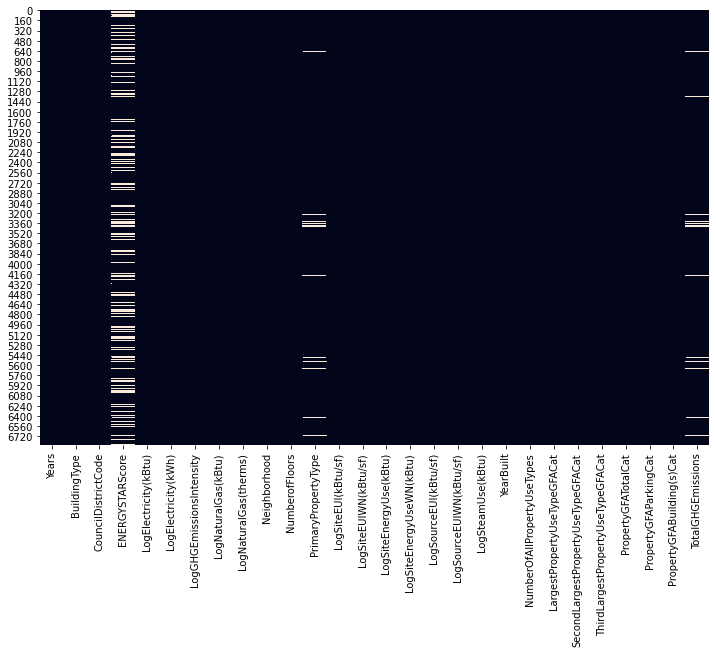

In [90]:
# Missing values visualization for the dataset that is used to predict the greenhouse gas emissions, including carbon dioxide
plt.figure(figsize = (12,8))
sns.heatmap(datalongCO2.isnull(), cbar=False)

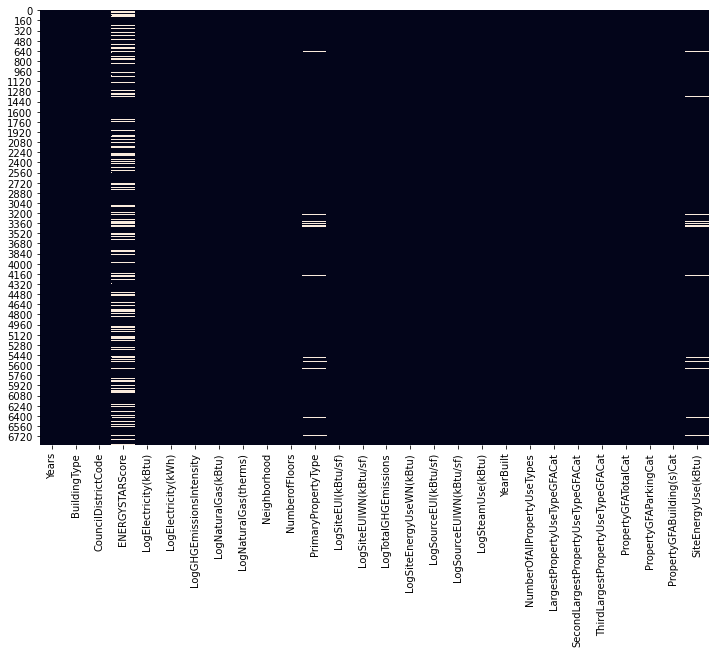

In [91]:
# Missing values visualization for the dataset that is used to predict the annual amount of energy consumed by the building
plt.figure(figsize = (12,8))
sns.heatmap(datalongCTE.isnull(), cbar=False)

In [92]:
# Let's drop all the observations with missing value in the target variable

# Greenhouse gas emissions, including carbon dioxide
datasetCO2 = datalongCO2[datalongCO2['TotalGHGEmissions'].notna()]

# Annual amount of energy consumed by the building
datasetCTE = datalongCTE[datalongCTE['SiteEnergyUse(kBtu)'].notna()]

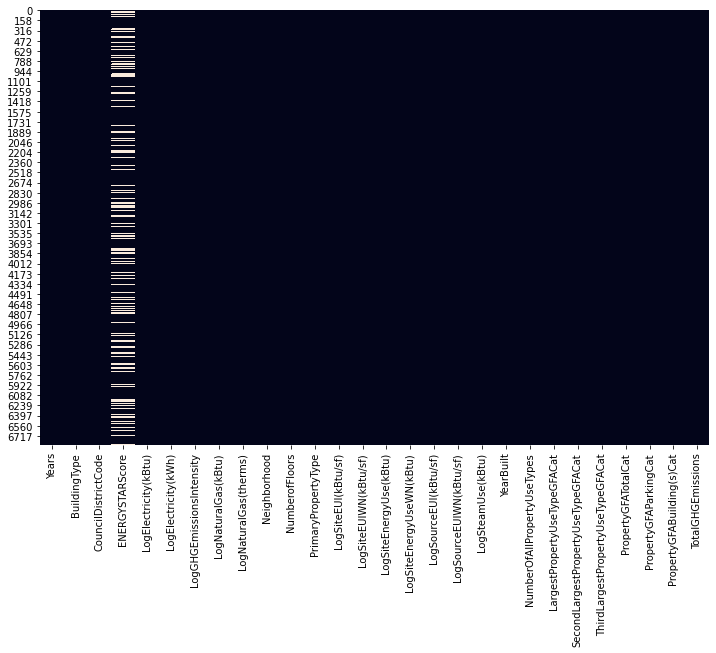

In [93]:
plt.figure(figsize = (12,8))
sns.heatmap(datasetCO2.isnull(), cbar=False)

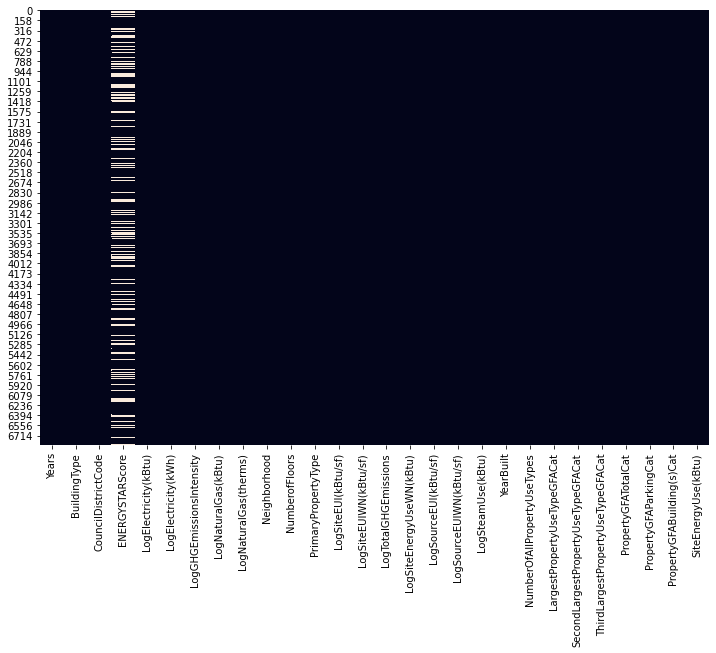

In [94]:
plt.figure(figsize = (12,8))
sns.heatmap(datasetCTE.isnull(), cbar=False)

### Transform none numeric variables to dummy variables

In [95]:
# List of none numeric variables
VARLIST = ['BuildingType','CouncilDistrictCode','Neighborhood', 'PrimaryPropertyType',
           'LargestPropertyUseTypeGFACat','SecondLargestPropertyUseTypeGFACat', 'ThirdLargestPropertyUseTypeGFACat',
           'PropertyGFATotalCat','PropertyGFAParkingCat', 'PropertyGFABuilding(s)Cat', 'Years']

In [96]:
# Greenhouse gas emissions, including carbon dioxide
DatasetFinalCO2 = pd.get_dummies(datasetCO2, columns = VARLIST, drop_first=True)

# Annual amount of energy consumed by the building
DatasetFinalCTE = pd.get_dummies(datasetCTE, columns = VARLIST, drop_first=True)

### Missing values imputation of Energystarscore using KNN algorithm

- Greenhouse gas emissions, including carbon dioxide

In [97]:
dt1 = DatasetFinalCO2[DatasetFinalCO2['ENERGYSTARScore'].notna()]
dt2 = DatasetFinalCO2[DatasetFinalCO2['ENERGYSTARScore'].isna()].drop(['ENERGYSTARScore'], axis = 1)

X1 = dt1.drop(['ENERGYSTARScore'], axis = 1).values
y1 = dt1['ENERGYSTARScore'].values

reg = GridSearchCV(KNeighborsRegressor(), 
                  {'n_neighbors':[5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
                  cv = 5)
reg.fit(X1, y1)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90,
                                         100]})

In [98]:
#Let's use dt2 to predict missing values

y_pred = np.floor(reg.predict(dt2))

# Missing values imputation using KNN algorithm

DatasetFinalCO2.loc[DatasetFinalCO2['ENERGYSTARScore'].isnull(),'ENERGYSTARScore'] = y_pred
DatasetFinalCO2['LogENERGYSTARScore'] = np.log(DatasetFinalCO2['ENERGYSTARScore'])
DatasetFinalCO2.drop('ENERGYSTARScore', axis = 1, inplace = True)

- Annual amount of energy consumed by the building

In [99]:
dt1 = DatasetFinalCTE[DatasetFinalCTE['ENERGYSTARScore'].notna()]
dt2 = DatasetFinalCTE[DatasetFinalCTE['ENERGYSTARScore'].isna()].drop(['ENERGYSTARScore'], axis = 1)

X1 = dt1.drop(['ENERGYSTARScore'], axis = 1).values
y1 = dt1['ENERGYSTARScore'].values

reg = GridSearchCV(KNeighborsRegressor(), 
                  {'n_neighbors':[5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
                  cv = 5)
reg.fit(X1, y1)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90,
                                         100]})

In [100]:
# Let's use dt2 to predict missing values

y_pred = np.floor(reg.predict(dt2))

# Missing values imputation using KNN algorithm

DatasetFinalCTE.loc[DatasetFinalCTE['ENERGYSTARScore'].isnull(),'ENERGYSTARScore'] = y_pred
DatasetFinalCTE['LogENERGYSTARScore'] = np.log(DatasetFinalCTE['ENERGYSTARScore'])
DatasetFinalCTE.drop('ENERGYSTARScore', axis = 1, inplace = True)

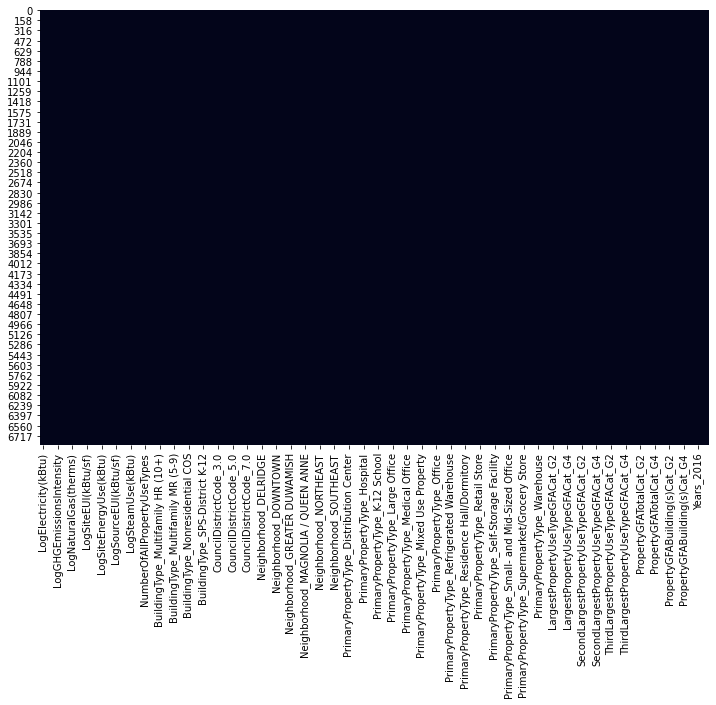

In [101]:
plt.figure(figsize = (12,8))
sns.heatmap(DatasetFinalCO2.isnull(), cbar=False)

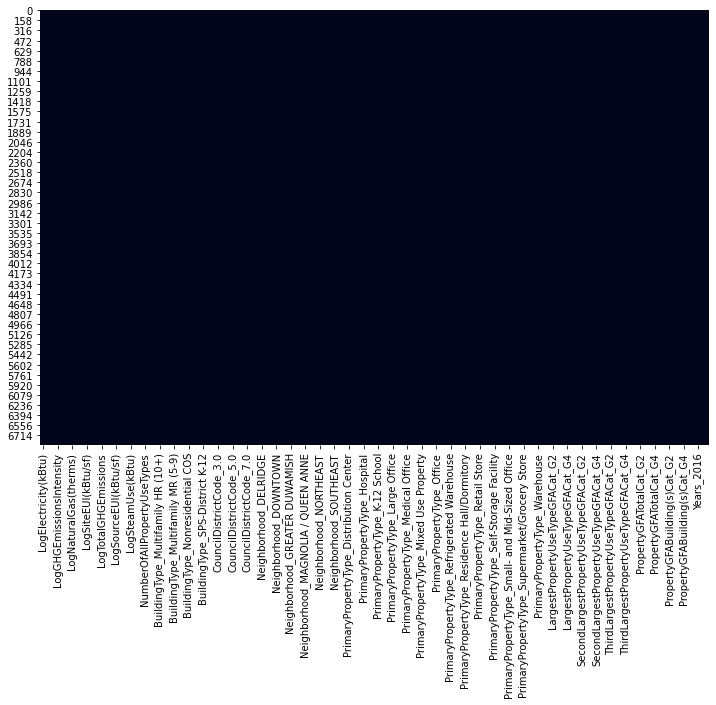

In [102]:
plt.figure(figsize = (12,8))
sns.heatmap(DatasetFinalCTE.isnull(), cbar=False)

Our datasets don't contain any missing value.

## Target variable transformation

Text(0.5, 1.0, 'LogSiteEnergyUse(kBtu)')

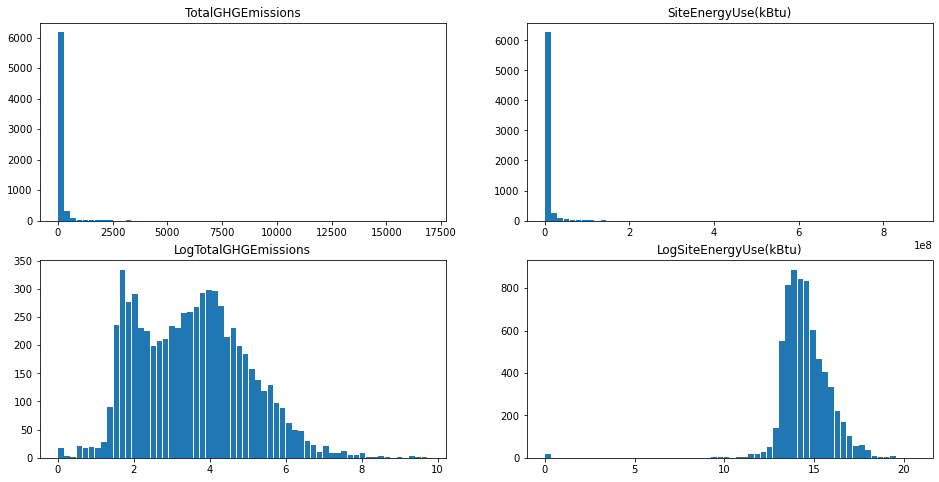

In [103]:
plt.figure(figsize = (16,8))
dt1 = DatasetFinalCO2['TotalGHGEmissions']
dt2 = DatasetFinalCTE['SiteEnergyUse(kBtu)']

ldt1 = np.log1p(DatasetFinalCO2['TotalGHGEmissions'])
ldt2 = np.log1p(DatasetFinalCTE['SiteEnergyUse(kBtu)'])
plt.subplot(2,2,1)
plt.hist(dt1, bins=60, rwidth=0.9)
plt.title('TotalGHGEmissions')
plt.subplot(2,2,2)
plt.hist(dt2, bins=60, rwidth=0.9)
plt.title('SiteEnergyUse(kBtu)')
plt.subplot(2,2,3)
plt.hist(ldt1, bins=60, rwidth=0.9)
plt.title('Log' + 'TotalGHGEmissions')
plt.subplot(2,2,4)
plt.hist(ldt2, bins=60, rwidth=0.9)
plt.title('Log' + 'SiteEnergyUse(kBtu)')

By taking the log of the target feature, the distribution becomes quite normal.

In [104]:
DatasetFinalCO2['LogTotalGHGEmissions'] = np.log1p(DatasetFinalCO2['TotalGHGEmissions'])
DatasetFinalCO2.drop('TotalGHGEmissions', axis = 1, inplace = True)

DatasetFinalCTE['LogSiteEnergyUse(kBtu)'] = np.log1p(DatasetFinalCTE['SiteEnergyUse(kBtu)'])
DatasetFinalCTE.drop('SiteEnergyUse(kBtu)', axis = 1, inplace = True)

# END of Data cleaning